Esse Notebook será dedicado a experimentar como os modelos classicos aprendem com os dados youtube e spotify.

* Primeiro será feito um teste com os modelos sem nenhum ajuste previo para entender como tão prevendo os dados em primeiro momento.

* Em segundo momento será testado como a idade dos dados ta afetenado previsão do modelo em 3 diferentes faixas de tempo.

* Retirar os outliers e ver como o modelo padrão de menor erro se comporta

possiveis melhorias:
*   tirar os outliers de engajamento
*   utilizar tecnicas como SMOTE para aumentar o numero de musicas com ate 30 dias
*   tirar outliers

Descobertas:
* Utilizar apenas musicas recentes não garante que vamos ter resultados melhores, portanto pode usar todas as musicas
* Musicas com mais dias são mais faceis de prever
* Retirar os outliers não trouxe grande melhoria
* Conforme vai ficando maior a idade dos videos mais preciso fica a regressão
* Se retirar os outliers do conjunto de treinamento o numero de streams ajuda na predição

In [ ]:
!pip install --upgrade google-colab bokeh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.2 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade optuna

In [ ]:
!pip install delu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!pip install rtdl_revisiting_models

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch.nn as nn
from sklearn.model_selection import PredefinedSplit

In [ ]:
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [ ]:
# ruff: noqa: E402
import math
import warnings
from typing import Dict, Literal

warnings.simplefilter("ignore")
import delu  # Deep Learning Utilities: https://github.com/Yura52/delu
import numpy as np
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm

warnings.resetwarnings()

from rtdl_revisiting_models import MLP, ResNet, FTTransformer

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set random seeds in all libraries.
delu.random.seed(0)

0

In [ ]:
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tratamento dos dados

In [ ]:
# Modify the Google Drive links to directly download the CSV content
spotify_youtube_pt1_url = "https://drive.google.com/uc?export=download&id=1PxI2XsRb9SRfTKJN_y8SmE_ZKs-oPMQS"
spotify_youtube_pt2_url = "https://drive.google.com/uc?export=download&id=1nqU-jJFCdiIZA3gVp3l6b9J1g6l-bKiL"

# Read the CSV files using the direct download links
spotify_youtube_pt1 = pd.read_csv(spotify_youtube_pt1_url)
spotify_youtube_pt2 = pd.read_csv(spotify_youtube_pt2_url)

In [ ]:
data_extracao = pd.to_datetime("2023-02-07")
spotify_youtube_pt1["upload_date"] = pd.to_datetime(spotify_youtube_pt1["upload_date"])
spotify_youtube_pt1["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt1["upload_date"]).dt.days

spotify_youtube_pt2["upload_date"] = pd.to_datetime(spotify_youtube_pt2["upload_date"])
spotify_youtube_pt2["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt2["upload_date"]).dt.days

In [ ]:
spotify_youtube = pd.concat([spotify_youtube_pt1,spotify_youtube_pt2])

In [ ]:
#spotify_youtube_dummies=pd.get_dummies(spotify_youtube,columns=['Album_type'], dtype=int)

In [ ]:
spotify_youtube.columns

Index(['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Album_type',
       'Uri', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Views', 'Likes',
       'Comments', 'Description', 'Licensed', 'official_video', 'Stream',
       'upload_date', 'dias_na_plataforma'],
      dtype='object')

In [ ]:
spotify_youtube['artist_number'] = spotify_youtube['Artist'].str.split(',').str.len()
spotify_youtube['engagement_rate'] = spotify_youtube.apply(lambda row: (row['Likes'] + row['Comments']) / row['Views'] * 100 if row['Views'] > 0 else 0, axis=1)

In [ ]:
columns_drop=['Unnamed: 0','Artist','Url_spotify', 'Track', 'Album', 'Uri','Url_youtube', 'Title', 'Channel', 'Views', 'Likes','Comments', 'Description', 'Licensed', 'official_video', 'upload_date']
spotify_youtube_df=spotify_youtube.drop(columns=columns_drop)

In [ ]:
spotify_youtube_df.columns

Index(['Album_type', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Stream', 'dias_na_plataforma',
       'artist_number', 'engagement_rate'],
      dtype='object')

In [ ]:
spotify_youtube_limpo=spotify_youtube_df.dropna(subset=['Album_type','Danceability','Energy','Key','Loudness','Speechiness','Acousticness', 'Instrumentalness','Liveness','Valence','Tempo','Duration_ms','engagement_rate','Stream'])

# Preparação dos dados para os experimentos

In [ ]:
youtube_30_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<31]
youtube_90_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<91]
youtube_365_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<366]

In [ ]:
youtube_30_df.columns

Index(['Album_type', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Stream', 'dias_na_plataforma',
       'artist_number', 'engagement_rate'],
      dtype='object')

In [ ]:
spotify_youtube_df_366_more = spotify_youtube_limpo.drop(youtube_365_df.index)
spotify_youtube_df_91_365 = youtube_365_df.drop(youtube_90_df.index)
spotify_youtube_df_31_90 = youtube_365_df.drop(youtube_30_df.index)

Total number of outliers in column engagement_rate: 573
Lower limit: -0.48890200173719367, Upper limit: 2.2530342121620657
-----------------------------------------------------------


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


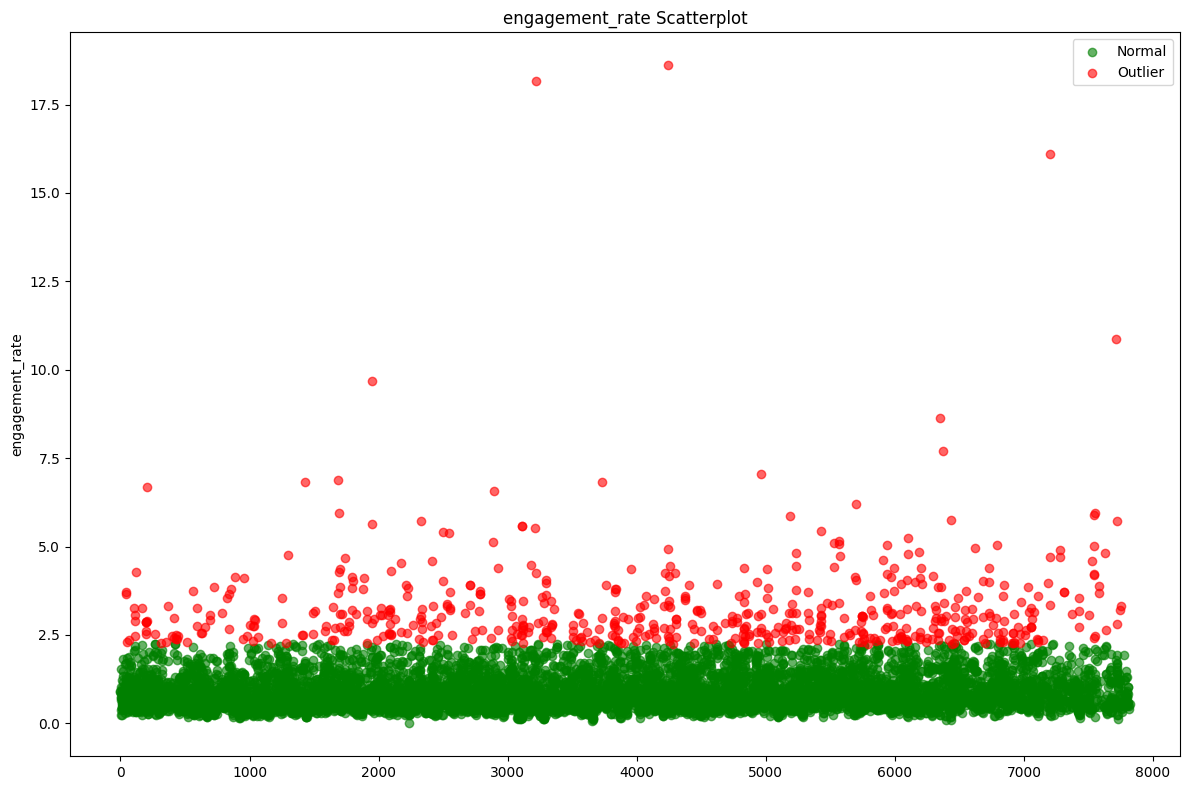

In [ ]:
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(spotify_youtube_df_366_more, col)


    normal_values = spotify_youtube_df_366_more[(spotify_youtube_df_366_more[col] >= lower) & (spotify_youtube_df_366_more[col] <= upper)]


    plt.subplot(1, 1, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()


    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

In [ ]:
youtube_30_df=youtube_30_df[youtube_30_df['engagement_rate']<9.338507725109846]
spotify_youtube_df_31_90=spotify_youtube_df_31_90[spotify_youtube_df_31_90['engagement_rate']<4.602401258613792]
spotify_youtube_df_31_90 = spotify_youtube_df_31_90[spotify_youtube_df_31_90['Album_type'] != 'compilation']

spotify_youtube_df_91_365=spotify_youtube_df_91_365[spotify_youtube_df_91_365['engagement_rate']<4.253191569584401]
spotify_youtube_df_91_365 = spotify_youtube_df_91_365[spotify_youtube_df_91_365['Album_type'] != 'compilation']

spotify_youtube_df_366_more=spotify_youtube_df_366_more[spotify_youtube_df_366_more['engagement_rate']<2.251193229196198]
spotify_youtube_df_366_more = spotify_youtube_df_366_more[spotify_youtube_df_366_more['Album_type'] != 'compilation']

In [ ]:
youtube_30_df_x = youtube_30_df.drop('engagement_rate',axis=1)
youtube_30_df_y = youtube_30_df['engagement_rate']

spotify_youtube_df_31_90_x = spotify_youtube_df_31_90.drop('engagement_rate',axis=1)
spotify_youtube_df_31_90_y = spotify_youtube_df_31_90['engagement_rate']

spotify_youtube_df_91_365_x = spotify_youtube_df_91_365.drop('engagement_rate',axis=1)
spotify_youtube_df_91_365_y = spotify_youtube_df_91_365['engagement_rate']

spotify_youtube_df_366_more_x = spotify_youtube_df_366_more.drop('engagement_rate',axis=1)
spotify_youtube_df_366_more_y = spotify_youtube_df_366_more['engagement_rate']

In [ ]:
spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=42)
spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=42)

In [ ]:
# Dados de treino
sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90_x,spotify_youtube_df_91_365_x,spotify_youtube_df_366_more_x])
sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90_y,spotify_youtube_df_91_365_y,spotify_youtube_df_366_more_y])

In [ ]:
sy_30_x_val=spotify_youtube_30X_val
sy_30_y_val=spotify_youtube_30y_val

In [ ]:
# Para testar o desempenho do modelo com videos com ate 30 dias
sy_30_x_test=spotify_youtube_30X_test
sy_30_y_test=spotify_youtube_30y_test


In [ ]:
sy_x_train['Album_type'] = sy_x_train['Album_type'].astype('category')
sy_x_train['Album_type'].cat.categories

Index(['album', 'single'], dtype='object')

In [ ]:
sy_30_x_val['Album_type'] = sy_30_x_val['Album_type'].astype('category')
sy_30_x_val['Album_type'].cat.categories


Index(['album', 'single'], dtype='object')

In [ ]:
sy_30_x_test['Album_type'] = sy_30_x_test['Album_type'].astype('category')
sy_30_x_test['Album_type'].cat.categories



Index(['album', 'single'], dtype='object')

# Transformers

In [ ]:
class YNormalizer:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, y):
        """Calcula a média e o desvio padrão."""
        self.mean_ = y.mean().item()
        self.std_ = y.std().item()

    def transform(self, y):
        """Normaliza os dados."""
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("Você precisa chamar 'fit' antes de 'transform'.")
        return (y - self.mean_) / self.std_

    def inverse_transform(self, y_normalized):
        """Volta para a escala original."""
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("Você precisa chamar 'fit' antes de 'inverse_transform'.")
        return y_normalized * self.std_ + self.mean_

teste com o modelo base com o trabalho de dados que eles fazem

In [ ]:
## Este é o codigo que prepara os dados para o modelo
# >>> Ajustando os dados para os Transformers
TaskType = Literal["regression", "binclass", "multiclass"]

task_type: TaskType = "regression"
n_classes = None

# Convertendo os conjuntos de treino, validação e teste para arrays NumPy
X_cont_train = sy_x_train.values.astype(np.float32)
Y_train = sy_y_train.values.astype(np.float32)

X_cont_val = sy_30_x_val.values.astype(np.float32)
Y_val = sy_30_y_val.values.astype(np.float32)

X_cont_test = sy_30_x_test.values.astype(np.float32)
Y_test = sy_30_y_test.values.astype(np.float32)

n_cont_features = X_cont_train.shape[1]

# >>> Labels.
if task_type == "regression":
    Y_train = Y_train.astype(np.float32)
    Y_val = Y_val.astype(np.float32)
    Y_test = Y_test.astype(np.float32)
else:
    assert n_classes is not None
    Y_train = Y_train.astype(np.int64)
    Y_val = Y_val.astype(np.int64)
    Y_test = Y_test.astype(np.int64)

# >>> Preparando os dados para treino, validação e teste
data_numpy = {
    "train": {"x_cont": X_cont_train, "y": Y_train},
    "val": {"x_cont": X_cont_val, "y": Y_val},
    "test": {"x_cont": X_cont_test, "y": Y_test},
}

# >>> Pré-processamento das features contínuas
X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)

preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

normalizer = YNormalizer()

# >>> Pré-processamento dos labels
if task_type == "regression":
    normalizer.fit(data_numpy["train"]["y"])

    for part in data_numpy:
        data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

# >>> Convertendo os dados para tensores
data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Requerido por F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()

cat_cardinalities=[]

In [ ]:
d_out = n_classes if task_type == "multiclass" else 1

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **FTTransformer.get_default_kwargs(),
).to(device)
optimizer = model.make_default_optimizer()

In [ ]:
def apply_model(batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, (MLP, ResNet)):
        x_cat_ohe = (
            [
                F.one_hot(column, cardinality)
                for column, cardinality in zip(batch["x_cat"].T, cat_cardinalities)
            ]
            if "x_cat" in batch
            else []
        )
        return model(torch.column_stack([batch["x_cont"]] + x_cat_ohe)).squeeze(-1)

    elif isinstance(model, FTTransformer):
        return model(batch["x_cont"], batch.get("x_cat")).squeeze(-1)

    else:
        raise RuntimeError(f"Unknown model type: {type(model)}")


loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == "binclass"
    else F.cross_entropy
    if task_type == "multiclass"
    else F.mse_loss
)


@torch.no_grad()
def evaluate(part: str) -> float:
    model.eval()

    eval_batch_size = 8096
    y_pred = (
        torch.cat(
            [
                apply_model(batch)
                for batch in delu.iter_batches(data[part], eval_batch_size)
            ]
        )
        .cpu()
        .numpy()
    )
    y_true = data[part]["y"].cpu().numpy()

    if task_type == "binclass":
        y_pred = np.round(scipy.special.expit(y_pred))
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    elif task_type == "multiclass":
        y_pred = y_pred.argmax(1)
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    else:
        assert task_type == "regression"
        mse = sklearn.metrics.mean_squared_error(normalizer.inverse_transform(y_true), normalizer.inverse_transform(y_pred))
        score = -(sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5 * normalizer.std_)
        #score = sklearn.metrics.mean_squared_error(y_true, y_pred)
    return score,mse  # The higher -- the better.

eval,_=evaluate("test")
print(f'Test score before training: {eval:.4f}')

Test score before training: -3.3911


In [ ]:
n_epochs = 1000
patience = 100

batch_size = 64
epoch_size = math.ceil(len(sy_x_train) / batch_size)
timer = delu.tools.Timer()

# MSE: queremos minimizar -> mode="min"
early_stopping = delu.tools.EarlyStopping(patience, mode="min")

best = {
    "val": float("inf"),
    "test": -math.inf,
    "mse": float("inf"),
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score,val_mse = evaluate("val")
    test_score,test_mse = evaluate("test")
    print(f"(val) {val_mse:.4f}  (test) {test_mse:.4f} [time] {timer}")

    early_stopping.update(val_mse)
    if early_stopping.should_stop():
        break

    if val_mse < best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_mse, "test":test_mse, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 199/199 [00:02<00:00, 97.58it/s] 


(val) 4.7108  (test) 4.9862 [time] 0:00:02.051971
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 199/199 [00:02<00:00, 98.96it/s]


(val) 5.2742  (test) 4.4914 [time] 0:00:04.075230



Epoch 2: 100%|██████████| 199/199 [00:02<00:00, 84.11it/s]


(val) 4.8755  (test) 4.6067 [time] 0:00:06.456954



Epoch 3: 100%|██████████| 199/199 [00:02<00:00, 79.26it/s]


(val) 4.8286  (test) 5.2134 [time] 0:00:08.982036



Epoch 4: 100%|██████████| 199/199 [00:02<00:00, 97.63it/s]


(val) 4.5433  (test) 4.6336 [time] 0:00:11.032333
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 199/199 [00:02<00:00, 99.47it/s]


(val) 5.1922  (test) 4.7201 [time] 0:00:13.044428



Epoch 6: 100%|██████████| 199/199 [00:02<00:00, 98.69it/s]


(val) 4.8953  (test) 4.8896 [time] 0:00:15.075279



Epoch 7: 100%|██████████| 199/199 [00:01<00:00, 99.67it/s]


(val) 4.6395  (test) 4.7511 [time] 0:00:17.083335



Epoch 8: 100%|██████████| 199/199 [00:02<00:00, 86.60it/s]


(val) 5.1426  (test) 4.8917 [time] 0:00:19.396435



Epoch 9: 100%|██████████| 199/199 [00:02<00:00, 78.82it/s]


(val) 5.1483  (test) 4.7774 [time] 0:00:21.934107



Epoch 10: 100%|██████████| 199/199 [00:02<00:00, 99.07it/s]


(val) 5.2061  (test) 4.3876 [time] 0:00:23.956319



Epoch 11: 100%|██████████| 199/199 [00:02<00:00, 97.96it/s]


(val) 4.6745  (test) 4.8625 [time] 0:00:25.999706



Epoch 12: 100%|██████████| 199/199 [00:02<00:00, 99.18it/s] 


(val) 4.2216  (test) 4.5518 [time] 0:00:28.019524
🌸 New best epoch! 🌸



Epoch 13: 100%|██████████| 199/199 [00:02<00:00, 97.86it/s]


(val) 4.3269  (test) 4.8202 [time] 0:00:30.067113



Epoch 14: 100%|██████████| 199/199 [00:02<00:00, 84.96it/s]


(val) 4.5422  (test) 4.8059 [time] 0:00:32.423477



Epoch 15: 100%|██████████| 199/199 [00:02<00:00, 77.96it/s]


(val) 4.4970  (test) 4.8142 [time] 0:00:34.990716



Epoch 16: 100%|██████████| 199/199 [00:02<00:00, 98.62it/s]


(val) 4.8561  (test) 4.6556 [time] 0:00:37.020736



Epoch 17: 100%|██████████| 199/199 [00:01<00:00, 100.12it/s]


(val) 4.7855  (test) 4.8798 [time] 0:00:39.021981



Epoch 18: 100%|██████████| 199/199 [00:02<00:00, 99.23it/s]


(val) 4.5930  (test) 4.6624 [time] 0:00:41.039323



Epoch 19: 100%|██████████| 199/199 [00:01<00:00, 100.00it/s]


(val) 4.9809  (test) 5.0126 [time] 0:00:43.041088



Epoch 20: 100%|██████████| 199/199 [00:02<00:00, 86.52it/s]


(val) 4.9735  (test) 4.9361 [time] 0:00:45.356967



Epoch 21: 100%|██████████| 199/199 [00:02<00:00, 78.12it/s]


(val) 4.7499  (test) 4.6704 [time] 0:00:47.918734



Epoch 22: 100%|██████████| 199/199 [00:01<00:00, 99.92it/s] 


(val) 4.8293  (test) 4.4672 [time] 0:00:49.922689



Epoch 23: 100%|██████████| 199/199 [00:02<00:00, 99.19it/s]


(val) 5.2625  (test) 4.5913 [time] 0:00:51.940746



Epoch 24: 100%|██████████| 199/199 [00:02<00:00, 99.17it/s] 


(val) 4.8099  (test) 4.7706 [time] 0:00:53.959943



Epoch 25: 100%|██████████| 199/199 [00:02<00:00, 99.04it/s] 


(val) 4.7447  (test) 4.5175 [time] 0:00:55.981663



Epoch 26: 100%|██████████| 199/199 [00:02<00:00, 85.89it/s]


(val) 4.3766  (test) 4.7693 [time] 0:00:58.318705



Epoch 27: 100%|██████████| 199/199 [00:02<00:00, 77.16it/s]


(val) 4.7085  (test) 4.5539 [time] 0:01:00.912092



Epoch 28: 100%|██████████| 199/199 [00:02<00:00, 97.95it/s]


(val) 5.2414  (test) 4.7585 [time] 0:01:02.957593



Epoch 29: 100%|██████████| 199/199 [00:02<00:00, 99.11it/s]


(val) 4.9375  (test) 4.4759 [time] 0:01:04.977863



Epoch 30: 100%|██████████| 199/199 [00:02<00:00, 98.71it/s]


(val) 5.0953  (test) 4.5501 [time] 0:01:07.009019



Epoch 31: 100%|██████████| 199/199 [00:01<00:00, 100.01it/s]


(val) 4.8294  (test) 4.5536 [time] 0:01:09.012405



Epoch 32: 100%|██████████| 199/199 [00:02<00:00, 86.24it/s]


(val) 4.7525  (test) 4.6052 [time] 0:01:11.336220



Epoch 33: 100%|██████████| 199/199 [00:02<00:00, 78.09it/s]


(val) 5.3548  (test) 4.5621 [time] 0:01:13.899810



Epoch 34: 100%|██████████| 199/199 [00:02<00:00, 99.14it/s] 


(val) 5.3955  (test) 4.6166 [time] 0:01:15.919409



Epoch 35: 100%|██████████| 199/199 [00:02<00:00, 91.30it/s]


(val) 5.1071  (test) 4.8512 [time] 0:01:18.150052



Epoch 36: 100%|██████████| 199/199 [00:02<00:00, 79.08it/s]


(val) 5.0396  (test) 4.6062 [time] 0:01:20.683739



Epoch 37: 100%|██████████| 199/199 [00:01<00:00, 99.62it/s]


(val) 5.1310  (test) 4.3722 [time] 0:01:22.694127



Epoch 38: 100%|██████████| 199/199 [00:02<00:00, 78.76it/s]


(val) 5.3169  (test) 4.6866 [time] 0:01:25.237425



Epoch 39: 100%|██████████| 199/199 [00:02<00:00, 85.31it/s]


(val) 4.2636  (test) 4.8360 [time] 0:01:27.583666



Epoch 40: 100%|██████████| 199/199 [00:01<00:00, 99.61it/s] 


(val) 4.2003  (test) 4.9277 [time] 0:01:29.594794
🌸 New best epoch! 🌸



Epoch 41: 100%|██████████| 199/199 [00:02<00:00, 98.08it/s]


(val) 4.2180  (test) 4.6884 [time] 0:01:31.636650



Epoch 42: 100%|██████████| 199/199 [00:02<00:00, 99.05it/s] 


(val) 4.0813  (test) 4.3749 [time] 0:01:33.659308
🌸 New best epoch! 🌸



Epoch 43: 100%|██████████| 199/199 [00:02<00:00, 99.29it/s] 


(val) 4.8647  (test) 4.4166 [time] 0:01:35.675285



Epoch 44: 100%|██████████| 199/199 [00:02<00:00, 78.24it/s]


(val) 4.4039  (test) 4.5031 [time] 0:01:38.236354



Epoch 45: 100%|██████████| 199/199 [00:02<00:00, 85.61it/s]


(val) 5.0115  (test) 4.2549 [time] 0:01:40.575418



Epoch 46: 100%|██████████| 199/199 [00:01<00:00, 99.52it/s]


(val) 4.6959  (test) 4.6551 [time] 0:01:42.586645



Epoch 47: 100%|██████████| 199/199 [00:01<00:00, 99.85it/s]


(val) 4.3977  (test) 4.9981 [time] 0:01:44.592823



Epoch 48: 100%|██████████| 199/199 [00:01<00:00, 99.72it/s]


(val) 4.3473  (test) 5.5948 [time] 0:01:46.600689



Epoch 49: 100%|██████████| 199/199 [00:01<00:00, 100.07it/s]


(val) 4.9418  (test) 4.7815 [time] 0:01:48.601630



Epoch 50: 100%|██████████| 199/199 [00:02<00:00, 80.63it/s]


(val) 4.4313  (test) 4.5359 [time] 0:01:51.084779



Epoch 51: 100%|██████████| 199/199 [00:02<00:00, 82.95it/s]


(val) 4.3714  (test) 4.7530 [time] 0:01:53.502776



Epoch 52: 100%|██████████| 199/199 [00:02<00:00, 98.94it/s]


(val) 4.8704  (test) 4.4673 [time] 0:01:55.525961



Epoch 53: 100%|██████████| 199/199 [00:01<00:00, 99.87it/s]


(val) 5.0781  (test) 4.6404 [time] 0:01:57.530333



Epoch 54: 100%|██████████| 199/199 [00:02<00:00, 98.92it/s]


(val) 4.4228  (test) 4.5392 [time] 0:01:59.555273



Epoch 55: 100%|██████████| 199/199 [00:02<00:00, 98.72it/s] 


(val) 4.5392  (test) 4.5098 [time] 0:02:01.583595



Epoch 56: 100%|██████████| 199/199 [00:02<00:00, 79.20it/s]


(val) 5.2965  (test) 4.4805 [time] 0:02:04.116778



Epoch 57: 100%|██████████| 199/199 [00:02<00:00, 81.99it/s]


(val) 4.4617  (test) 4.2345 [time] 0:02:06.558351



Epoch 58: 100%|██████████| 199/199 [00:02<00:00, 99.28it/s]


(val) 4.2954  (test) 4.7827 [time] 0:02:08.574982



Epoch 59: 100%|██████████| 199/199 [00:02<00:00, 97.63it/s]


(val) 4.3872  (test) 4.7859 [time] 0:02:10.627600



Epoch 60: 100%|██████████| 199/199 [00:02<00:00, 99.36it/s]


(val) 4.3629  (test) 4.6055 [time] 0:02:12.641930



Epoch 61: 100%|██████████| 199/199 [00:02<00:00, 98.23it/s]


(val) 4.3665  (test) 4.7904 [time] 0:02:14.680531



Epoch 62: 100%|██████████| 199/199 [00:02<00:00, 78.73it/s]


(val) 4.7648  (test) 4.8819 [time] 0:02:17.225451



Epoch 63: 100%|██████████| 199/199 [00:02<00:00, 84.37it/s]


(val) 4.6479  (test) 5.0774 [time] 0:02:19.599483



Epoch 64: 100%|██████████| 199/199 [00:01<00:00, 100.07it/s]


(val) 4.1285  (test) 4.7462 [time] 0:02:21.600410



Epoch 65: 100%|██████████| 199/199 [00:01<00:00, 99.94it/s] 


(val) 4.2478  (test) 4.6122 [time] 0:02:23.603474



Epoch 66: 100%|██████████| 199/199 [00:01<00:00, 99.91it/s] 


(val) 4.0504  (test) 4.7341 [time] 0:02:25.608733
🌸 New best epoch! 🌸



Epoch 67: 100%|██████████| 199/199 [00:01<00:00, 99.66it/s]


(val) 4.1691  (test) 4.9568 [time] 0:02:27.619089



Epoch 68: 100%|██████████| 199/199 [00:02<00:00, 80.11it/s]


(val) 5.0252  (test) 4.6008 [time] 0:02:30.119439



Epoch 69: 100%|██████████| 199/199 [00:02<00:00, 83.07it/s]


(val) 4.1752  (test) 4.8400 [time] 0:02:32.528042



Epoch 70: 100%|██████████| 199/199 [00:02<00:00, 98.88it/s]


(val) 4.3807  (test) 5.0277 [time] 0:02:34.554069



Epoch 71: 100%|██████████| 199/199 [00:02<00:00, 97.08it/s]


(val) 4.8577  (test) 4.6585 [time] 0:02:36.616442



Epoch 72: 100%|██████████| 199/199 [00:02<00:00, 98.59it/s]


(val) 4.1891  (test) 4.7753 [time] 0:02:38.647172



Epoch 73: 100%|██████████| 199/199 [00:02<00:00, 99.41it/s]


(val) 4.1229  (test) 4.9281 [time] 0:02:40.662417



Epoch 74: 100%|██████████| 199/199 [00:02<00:00, 80.25it/s]


(val) 4.8170  (test) 5.1885 [time] 0:02:43.158301



Epoch 75: 100%|██████████| 199/199 [00:02<00:00, 83.15it/s]


(val) 4.4296  (test) 5.0891 [time] 0:02:45.565589



Epoch 76: 100%|██████████| 199/199 [00:02<00:00, 98.53it/s]


(val) 4.3979  (test) 4.6734 [time] 0:02:47.598368



Epoch 77: 100%|██████████| 199/199 [00:02<00:00, 98.70it/s]


(val) 5.1799  (test) 5.0542 [time] 0:02:49.629250



Epoch 78: 100%|██████████| 199/199 [00:01<00:00, 100.49it/s]


(val) 4.4776  (test) 5.0750 [time] 0:02:51.622085



Epoch 79: 100%|██████████| 199/199 [00:01<00:00, 99.62it/s]


(val) 4.9319  (test) 4.8653 [time] 0:02:53.631813



Epoch 80: 100%|██████████| 199/199 [00:02<00:00, 78.84it/s]


(val) 5.6976  (test) 4.2828 [time] 0:02:56.172785



Epoch 81: 100%|██████████| 199/199 [00:02<00:00, 83.18it/s]


(val) 5.3253  (test) 4.7419 [time] 0:02:58.580144



Epoch 82: 100%|██████████| 199/199 [00:02<00:00, 98.82it/s]


(val) 5.4476  (test) 4.3603 [time] 0:03:00.607493



Epoch 83: 100%|██████████| 199/199 [00:02<00:00, 98.46it/s]


(val) 5.0910  (test) 4.2935 [time] 0:03:02.642327



Epoch 84: 100%|██████████| 199/199 [00:02<00:00, 99.16it/s]


(val) 5.1122  (test) 4.7325 [time] 0:03:04.661578



Epoch 85: 100%|██████████| 199/199 [00:02<00:00, 80.34it/s]


(val) 4.2397  (test) 4.5309 [time] 0:03:07.152253



Epoch 86: 100%|██████████| 199/199 [00:02<00:00, 72.30it/s]


(val) 5.0172  (test) 4.8207 [time] 0:03:09.923377



Epoch 87: 100%|██████████| 199/199 [00:02<00:00, 93.49it/s]


(val) 4.5915  (test) 4.4900 [time] 0:03:12.070343



Epoch 88: 100%|██████████| 199/199 [00:02<00:00, 98.84it/s]


(val) 4.4765  (test) 4.8904 [time] 0:03:14.097475



Epoch 89: 100%|██████████| 199/199 [00:01<00:00, 99.86it/s]


(val) 5.2365  (test) 4.7479 [time] 0:03:16.103117



Epoch 90: 100%|██████████| 199/199 [00:02<00:00, 99.31it/s]


(val) 5.5701  (test) 4.8678 [time] 0:03:18.119602



Epoch 91: 100%|██████████| 199/199 [00:02<00:00, 99.34it/s]


(val) 5.4591  (test) 4.7784 [time] 0:03:20.135954



Epoch 92: 100%|██████████| 199/199 [00:02<00:00, 73.10it/s]


(val) 5.1298  (test) 4.7551 [time] 0:03:22.879422



Epoch 93: 100%|██████████| 199/199 [00:02<00:00, 93.08it/s]


(val) 4.8140  (test) 4.8253 [time] 0:03:25.034626



Epoch 94: 100%|██████████| 199/199 [00:02<00:00, 98.81it/s]


(val) 5.0023  (test) 5.1823 [time] 0:03:27.062498



Epoch 95: 100%|██████████| 199/199 [00:02<00:00, 99.23it/s] 


(val) 5.0368  (test) 5.1386 [time] 0:03:29.081762



Epoch 96: 100%|██████████| 199/199 [00:02<00:00, 98.22it/s]


(val) 4.9155  (test) 5.1686 [time] 0:03:31.122546



Epoch 97: 100%|██████████| 199/199 [00:02<00:00, 98.64it/s]


(val) 4.8704  (test) 5.1735 [time] 0:03:33.153444



Epoch 98: 100%|██████████| 199/199 [00:02<00:00, 72.16it/s]


(val) 4.4644  (test) 5.0172 [time] 0:03:35.927584



Epoch 99: 100%|██████████| 199/199 [00:02<00:00, 80.52it/s]


(val) 4.6358  (test) 4.8372 [time] 0:03:38.423778



Epoch 100: 100%|██████████| 199/199 [00:02<00:00, 68.53it/s]


(val) 5.1079  (test) 4.9006 [time] 0:03:41.356468



Epoch 101: 100%|██████████| 199/199 [00:02<00:00, 71.09it/s]


(val) 4.9258  (test) 5.1196 [time] 0:03:44.177939



Epoch 102: 100%|██████████| 199/199 [00:04<00:00, 42.84it/s]


(val) 5.4881  (test) 5.2940 [time] 0:03:48.846802



Epoch 103: 100%|██████████| 199/199 [00:02<00:00, 72.44it/s]


(val) 4.7168  (test) 4.9597 [time] 0:03:51.614893



Epoch 104: 100%|██████████| 199/199 [00:02<00:00, 98.62it/s]


(val) 4.8087  (test) 4.8626 [time] 0:03:53.645173



Epoch 105: 100%|██████████| 199/199 [00:02<00:00, 98.94it/s]


(val) 4.6245  (test) 4.9140 [time] 0:03:55.669003



Epoch 106: 100%|██████████| 199/199 [00:02<00:00, 83.92it/s]


(val) 4.9366  (test) 4.8804 [time] 0:03:58.056323



Epoch 107: 100%|██████████| 199/199 [00:02<00:00, 76.37it/s]


(val) 5.0232  (test) 4.6994 [time] 0:04:00.682222



Epoch 108: 100%|██████████| 199/199 [00:03<00:00, 62.80it/s]


(val) 5.0255  (test) 4.7983 [time] 0:04:03.866673



Epoch 109: 100%|██████████| 199/199 [00:02<00:00, 91.50it/s]


(val) 5.5848  (test) 4.7773 [time] 0:04:06.056579



Epoch 110: 100%|██████████| 199/199 [00:02<00:00, 81.81it/s]


(val) 4.8429  (test) 4.7545 [time] 0:04:08.502101



Epoch 111: 100%|██████████| 199/199 [00:02<00:00, 88.27it/s]


(val) 5.6546  (test) 5.0167 [time] 0:04:10.768328



Epoch 112: 100%|██████████| 199/199 [00:02<00:00, 89.74it/s]


(val) 4.0197  (test) 4.9972 [time] 0:04:12.998302
🌸 New best epoch! 🌸



Epoch 113: 100%|██████████| 199/199 [00:02<00:00, 67.81it/s]


(val) 4.1021  (test) 5.0775 [time] 0:04:15.969732



Epoch 114: 100%|██████████| 199/199 [00:04<00:00, 46.51it/s]


(val) 5.1299  (test) 4.9572 [time] 0:04:20.282109



Epoch 115: 100%|██████████| 199/199 [00:02<00:00, 70.52it/s]


(val) 4.5478  (test) 4.8415 [time] 0:04:23.121989



Epoch 116: 100%|██████████| 199/199 [00:02<00:00, 97.73it/s]


(val) 4.3508  (test) 5.0695 [time] 0:04:25.170707



Epoch 117: 100%|██████████| 199/199 [00:02<00:00, 99.10it/s]


(val) 5.1209  (test) 4.8799 [time] 0:04:27.194673



Epoch 118: 100%|██████████| 199/199 [00:02<00:00, 72.14it/s]


(val) 4.9603  (test) 4.9803 [time] 0:04:29.972355



Epoch 119: 100%|██████████| 199/199 [00:02<00:00, 74.53it/s]


(val) 5.1259  (test) 5.1670 [time] 0:04:32.657021



Epoch 120: 100%|██████████| 199/199 [00:02<00:00, 85.89it/s]


(val) 4.6938  (test) 4.8520 [time] 0:04:34.989199



Epoch 121: 100%|██████████| 199/199 [00:02<00:00, 67.52it/s]


(val) 4.9089  (test) 5.0211 [time] 0:04:37.952234



Epoch 122: 100%|██████████| 199/199 [00:02<00:00, 87.43it/s]


(val) 3.9918  (test) 4.9649 [time] 0:04:40.241497
🌸 New best epoch! 🌸



Epoch 123: 100%|██████████| 199/199 [00:03<00:00, 64.90it/s]


(val) 5.0152  (test) 4.5897 [time] 0:04:43.329472



Epoch 124: 100%|██████████| 199/199 [00:02<00:00, 81.45it/s]


(val) 4.7418  (test) 4.5867 [time] 0:04:45.796993



Epoch 125: 100%|██████████| 199/199 [00:03<00:00, 55.96it/s]


(val) 5.3556  (test) 4.5497 [time] 0:04:49.387606



Epoch 126: 100%|██████████| 199/199 [00:02<00:00, 97.04it/s]


(val) 4.9899  (test) 4.5232 [time] 0:04:51.453272



Epoch 127: 100%|██████████| 199/199 [00:02<00:00, 96.54it/s]


(val) 4.7667  (test) 4.7393 [time] 0:04:53.532680



Epoch 128: 100%|██████████| 199/199 [00:02<00:00, 70.70it/s]


(val) 5.1280  (test) 4.6236 [time] 0:04:56.372266



Epoch 129: 100%|██████████| 199/199 [00:02<00:00, 95.65it/s]


(val) 5.0384  (test) 4.5132 [time] 0:04:58.465258



Epoch 130: 100%|██████████| 199/199 [00:02<00:00, 99.17it/s] 


(val) 5.0390  (test) 4.5127 [time] 0:05:00.485887



Epoch 131: 100%|██████████| 199/199 [00:02<00:00, 97.67it/s]


(val) 4.9512  (test) 4.9180 [time] 0:05:02.537777



Epoch 132: 100%|██████████| 199/199 [00:02<00:00, 98.58it/s]


(val) 5.1332  (test) 4.5533 [time] 0:05:04.570392



Epoch 133: 100%|██████████| 199/199 [00:02<00:00, 93.31it/s]


(val) 5.1763  (test) 4.7236 [time] 0:05:06.720811



Epoch 134: 100%|██████████| 199/199 [00:02<00:00, 70.45it/s]


(val) 5.3218  (test) 4.7737 [time] 0:05:09.557552



Epoch 135: 100%|██████████| 199/199 [00:02<00:00, 97.86it/s]


(val) 5.2443  (test) 4.6947 [time] 0:05:11.603601



Epoch 136: 100%|██████████| 199/199 [00:02<00:00, 95.93it/s]


(val) 5.2045  (test) 5.4718 [time] 0:05:13.691230



Epoch 137: 100%|██████████| 199/199 [00:02<00:00, 96.01it/s]


(val) 6.4103  (test) 4.4487 [time] 0:05:15.777541



Epoch 138: 100%|██████████| 199/199 [00:02<00:00, 98.91it/s]


(val) 4.9902  (test) 4.8312 [time] 0:05:17.803512



Epoch 139: 100%|██████████| 199/199 [00:02<00:00, 90.53it/s]


(val) 4.8066  (test) 4.8711 [time] 0:05:20.016873



Epoch 140: 100%|██████████| 199/199 [00:02<00:00, 70.44it/s]


(val) 5.1519  (test) 4.9067 [time] 0:05:22.858250



Epoch 141: 100%|██████████| 199/199 [00:02<00:00, 96.06it/s]


(val) 5.1674  (test) 4.7569 [time] 0:05:24.944753



Epoch 142: 100%|██████████| 199/199 [00:02<00:00, 97.39it/s]


(val) 5.4338  (test) 4.8553 [time] 0:05:27.004600



Epoch 143: 100%|██████████| 199/199 [00:02<00:00, 81.27it/s]


(val) 5.5286  (test) 4.8281 [time] 0:05:29.466200



Epoch 144: 100%|██████████| 199/199 [00:02<00:00, 97.60it/s]


(val) 6.0879  (test) 4.3796 [time] 0:05:31.521312



Epoch 145: 100%|██████████| 199/199 [00:02<00:00, 83.12it/s]


(val) 5.5082  (test) 4.8441 [time] 0:05:33.932639



Epoch 146: 100%|██████████| 199/199 [00:02<00:00, 77.38it/s]


(val) 6.4123  (test) 5.0045 [time] 0:05:36.520210



Epoch 147: 100%|██████████| 199/199 [00:02<00:00, 98.86it/s]


(val) 5.6744  (test) 4.5409 [time] 0:05:38.546962



Epoch 148: 100%|██████████| 199/199 [00:02<00:00, 97.40it/s]


(val) 5.4959  (test) 4.5194 [time] 0:05:40.604116



Epoch 149: 100%|██████████| 199/199 [00:02<00:00, 98.20it/s]


(val) 5.7653  (test) 4.7628 [time] 0:05:42.644854



Epoch 150: 100%|██████████| 199/199 [00:02<00:00, 99.13it/s] 


(val) 5.4292  (test) 4.7179 [time] 0:05:44.669194



Epoch 151: 100%|██████████| 199/199 [00:02<00:00, 83.68it/s]


(val) 5.2701  (test) 5.0078 [time] 0:05:47.063236



Epoch 152: 100%|██████████| 199/199 [00:02<00:00, 77.97it/s]


(val) 5.7031  (test) 5.1996 [time] 0:05:49.631494



Epoch 153: 100%|██████████| 199/199 [00:02<00:00, 99.18it/s]


(val) 5.3038  (test) 4.8600 [time] 0:05:51.651277



Epoch 154: 100%|██████████| 199/199 [00:02<00:00, 98.37it/s]


(val) 5.2667  (test) 5.3542 [time] 0:05:53.690268



Epoch 155: 100%|██████████| 199/199 [00:02<00:00, 96.39it/s]


(val) 5.7929  (test) 4.9255 [time] 0:05:55.767588



Epoch 156: 100%|██████████| 199/199 [00:02<00:00, 98.66it/s]


(val) 5.8112  (test) 4.9928 [time] 0:05:57.797670



Epoch 157: 100%|██████████| 199/199 [00:02<00:00, 82.47it/s]


(val) 5.5295  (test) 4.8077 [time] 0:06:00.229773



Epoch 158: 100%|██████████| 199/199 [00:02<00:00, 78.92it/s]


(val) 4.8098  (test) 4.7675 [time] 0:06:02.766254



Epoch 159: 100%|██████████| 199/199 [00:02<00:00, 98.44it/s]


(val) 5.3237  (test) 4.6642 [time] 0:06:04.799852



Epoch 160: 100%|██████████| 199/199 [00:02<00:00, 96.72it/s]


(val) 5.6027  (test) 4.6980 [time] 0:06:06.871608



Epoch 161: 100%|██████████| 199/199 [00:02<00:00, 97.32it/s]


(val) 5.5426  (test) 4.7733 [time] 0:06:08.929387



Epoch 162: 100%|██████████| 199/199 [00:02<00:00, 97.15it/s]


(val) 5.3005  (test) 4.8187 [time] 0:06:10.992061



Epoch 163: 100%|██████████| 199/199 [00:02<00:00, 79.78it/s]


(val) 4.9647  (test) 4.9595 [time] 0:06:13.505459



Epoch 164: 100%|██████████| 199/199 [00:02<00:00, 80.89it/s]


(val) 5.1983  (test) 4.4303 [time] 0:06:15.981125



Epoch 165: 100%|██████████| 199/199 [00:02<00:00, 96.98it/s]


(val) 4.1845  (test) 4.7214 [time] 0:06:18.045611



Epoch 166: 100%|██████████| 199/199 [00:02<00:00, 98.80it/s]


(val) 4.6935  (test) 4.7498 [time] 0:06:20.073791



Epoch 167: 100%|██████████| 199/199 [00:02<00:00, 98.05it/s]


(val) 4.4333  (test) 4.6090 [time] 0:06:22.117573



Epoch 168: 100%|██████████| 199/199 [00:02<00:00, 98.93it/s]


(val) 4.7722  (test) 4.4118 [time] 0:06:24.141781



Epoch 169: 100%|██████████| 199/199 [00:02<00:00, 78.84it/s]


(val) 6.0254  (test) 5.1132 [time] 0:06:26.682900



Epoch 170: 100%|██████████| 199/199 [00:02<00:00, 80.41it/s]


(val) 5.5559  (test) 5.3724 [time] 0:06:29.172156



Epoch 171: 100%|██████████| 199/199 [00:02<00:00, 95.60it/s]


(val) 5.3014  (test) 4.7009 [time] 0:06:31.269727



Epoch 172: 100%|██████████| 199/199 [00:02<00:00, 98.35it/s]


(val) 5.5164  (test) 4.7034 [time] 0:06:33.306418



Epoch 173: 100%|██████████| 199/199 [00:02<00:00, 98.75it/s]


(val) 4.5536  (test) 4.8657 [time] 0:06:35.333818



Epoch 174: 100%|██████████| 199/199 [00:02<00:00, 98.65it/s]


(val) 4.4991  (test) 4.7438 [time] 0:06:37.366397



Epoch 175: 100%|██████████| 199/199 [00:02<00:00, 78.15it/s]


(val) 4.2682  (test) 5.1691 [time] 0:06:39.931686



Epoch 176: 100%|██████████| 199/199 [00:02<00:00, 83.45it/s]


(val) 4.4097  (test) 4.6317 [time] 0:06:42.331253



Epoch 177: 100%|██████████| 199/199 [00:02<00:00, 97.78it/s] 


(val) 5.0683  (test) 4.5415 [time] 0:06:44.378551



Epoch 178: 100%|██████████| 199/199 [00:02<00:00, 98.49it/s] 


(val) 4.7667  (test) 4.3607 [time] 0:06:46.413753



Epoch 179: 100%|██████████| 199/199 [00:02<00:00, 97.51it/s]


(val) 4.7709  (test) 4.5064 [time] 0:06:48.467714



Epoch 180: 100%|██████████| 199/199 [00:02<00:00, 98.62it/s]


(val) 4.5387  (test) 4.5149 [time] 0:06:50.501682



Epoch 181: 100%|██████████| 199/199 [00:02<00:00, 74.53it/s]


(val) 4.5491  (test) 4.5427 [time] 0:06:53.188405



Epoch 182: 100%|██████████| 199/199 [00:02<00:00, 86.20it/s]


(val) 5.3972  (test) 4.7882 [time] 0:06:55.510351



Epoch 183: 100%|██████████| 199/199 [00:02<00:00, 98.35it/s] 


(val) 4.8239  (test) 4.3348 [time] 0:06:57.552377



Epoch 184: 100%|██████████| 199/199 [00:02<00:00, 96.76it/s]


(val) 5.2354  (test) 4.5183 [time] 0:06:59.624191



Epoch 185: 100%|██████████| 199/199 [00:02<00:00, 95.36it/s]


(val) 5.0120  (test) 4.3113 [time] 0:07:01.725170



Epoch 186: 100%|██████████| 199/199 [00:02<00:00, 98.42it/s]


(val) 4.9500  (test) 4.3393 [time] 0:07:03.762948



Epoch 187: 100%|██████████| 199/199 [00:02<00:00, 72.56it/s]


(val) 4.8577  (test) 4.2955 [time] 0:07:06.527982



Epoch 188: 100%|██████████| 199/199 [00:02<00:00, 89.87it/s]


(val) 4.8299  (test) 4.5033 [time] 0:07:08.754592



Epoch 189: 100%|██████████| 199/199 [00:02<00:00, 96.56it/s]


(val) 4.6794  (test) 4.5637 [time] 0:07:10.830205



Epoch 190: 100%|██████████| 199/199 [00:02<00:00, 96.93it/s]


(val) 4.8174  (test) 4.6980 [time] 0:07:12.899637



Epoch 191: 100%|██████████| 199/199 [00:02<00:00, 94.88it/s]


(val) 4.9436  (test) 4.5308 [time] 0:07:15.013987



Epoch 192: 100%|██████████| 199/199 [00:02<00:00, 94.81it/s]


(val) 4.9083  (test) 4.6146 [time] 0:07:17.132324



Epoch 193: 100%|██████████| 199/199 [00:02<00:00, 70.21it/s]


(val) 4.9102  (test) 4.7319 [time] 0:07:19.990326



Epoch 194: 100%|██████████| 199/199 [00:02<00:00, 95.55it/s]


(val) 4.9415  (test) 4.7443 [time] 0:07:22.085830



Epoch 195: 100%|██████████| 199/199 [00:01<00:00, 100.37it/s]


(val) 5.0991  (test) 4.7649 [time] 0:07:24.082525



Epoch 196: 100%|██████████| 199/199 [00:02<00:00, 98.27it/s]


(val) 4.9344  (test) 4.3904 [time] 0:07:26.121257



Epoch 197: 100%|██████████| 199/199 [00:02<00:00, 98.90it/s]


(val) 4.7218  (test) 4.8672 [time] 0:07:28.148240



Epoch 198: 100%|██████████| 199/199 [00:02<00:00, 93.80it/s]


(val) 4.8039  (test) 4.6710 [time] 0:07:30.283621



Epoch 199: 100%|██████████| 199/199 [00:02<00:00, 68.76it/s]


(val) 4.3354  (test) 4.5996 [time] 0:07:33.199151



Epoch 200: 100%|██████████| 199/199 [00:02<00:00, 96.95it/s]


(val) 4.2268  (test) 4.5668 [time] 0:07:35.268512



Epoch 201: 100%|██████████| 199/199 [00:02<00:00, 96.84it/s]


(val) 4.3704  (test) 4.8012 [time] 0:07:37.337088



Epoch 202: 100%|██████████| 199/199 [00:02<00:00, 98.70it/s]


(val) 4.3172  (test) 4.6746 [time] 0:07:39.367728



Epoch 203: 100%|██████████| 199/199 [00:02<00:00, 98.25it/s]


(val) 4.9513  (test) 4.5346 [time] 0:07:41.407810



Epoch 204: 100%|██████████| 199/199 [00:02<00:00, 92.04it/s]


(val) 4.9452  (test) 4.4598 [time] 0:07:43.589940



Epoch 205: 100%|██████████| 199/199 [00:02<00:00, 71.20it/s]


(val) 4.8747  (test) 4.6479 [time] 0:07:46.400566



Epoch 206: 100%|██████████| 199/199 [00:02<00:00, 74.64it/s]


(val) 5.3893  (test) 4.5119 [time] 0:07:49.079089



Epoch 207: 100%|██████████| 199/199 [00:02<00:00, 97.69it/s]


(val) 4.7068  (test) 4.3732 [time] 0:07:51.128382



Epoch 208: 100%|██████████| 199/199 [00:02<00:00, 97.84it/s] 


(val) 4.7763  (test) 4.5618 [time] 0:07:53.177942



Epoch 209: 100%|██████████| 199/199 [00:02<00:00, 97.06it/s]


(val) 5.4343  (test) 4.2985 [time] 0:07:55.241498



Epoch 210: 100%|██████████| 199/199 [00:02<00:00, 82.52it/s]


(val) 5.5887  (test) 4.7071 [time] 0:07:57.669953



Epoch 211: 100%|██████████| 199/199 [00:02<00:00, 77.95it/s]


(val) 4.9929  (test) 4.4757 [time] 0:08:00.238623



Epoch 212: 100%|██████████| 199/199 [00:02<00:00, 97.21it/s]


(val) 5.6257  (test) 4.8392 [time] 0:08:02.298669



Epoch 213: 100%|██████████| 199/199 [00:02<00:00, 98.24it/s]


(val) 4.7962  (test) 4.9005 [time] 0:08:04.337852



Epoch 214: 100%|██████████| 199/199 [00:04<00:00, 47.97it/s]


(val) 5.3759  (test) 4.8213 [time] 0:08:08.517333



Epoch 215: 100%|██████████| 199/199 [00:05<00:00, 38.18it/s]


(val) 5.9550  (test) 4.7549 [time] 0:08:13.743085



Epoch 216: 100%|██████████| 199/199 [00:02<00:00, 97.04it/s]


(val) 6.1039  (test) 4.7768 [time] 0:08:15.806497



Epoch 217: 100%|██████████| 199/199 [00:02<00:00, 93.12it/s]


(val) 5.9006  (test) 4.8352 [time] 0:08:17.965778



Epoch 218: 100%|██████████| 199/199 [00:02<00:00, 86.83it/s]


(val) 5.5736  (test) 4.6320 [time] 0:08:20.281435



Epoch 219: 100%|██████████| 199/199 [00:02<00:00, 85.68it/s]


(val) 5.4151  (test) 4.8573 [time] 0:08:22.617121



Epoch 220: 100%|██████████| 199/199 [00:04<00:00, 40.91it/s]


(val) 5.4513  (test) 4.4449 [time] 0:08:27.504449



Epoch 221: 100%|██████████| 199/199 [00:02<00:00, 88.23it/s]


(val) 5.0669  (test) 4.4508 [time] 0:08:29.784056



Epoch 222: 100%|██████████| 199/199 [00:02<00:00, 96.71it/s]

(val) 5.2748  (test) 4.7586 [time] 0:08:31.856364


Result:
{'val': 3.991842269897461, 'test': 4.964905738830566, 'epoch': 122}


teste do modelo com modificações no fluxo de preprocessamento

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## Este é o codigo que prepara os dados para o modelo
# >>> Ajustando os dados para os Transformers
TaskType = Literal["regression", "binclass", "multiclass"]

task_type: TaskType = "regression"
n_classes = None
# Separate 'Album_type' and other features
album_type_train = sy_x_train[['Album_type']]
album_type_val = sy_30_x_val[['Album_type']]
album_type_test = sy_30_x_test[['Album_type']]

other_features_train = sy_x_train.drop(columns=['Album_type'])
other_features_val = sy_30_x_val.drop(columns=['Album_type'])
other_features_test = sy_30_x_test.drop(columns=['Album_type'])


# Concatenate encoded 'Album_type' with other features
X_cont_train = other_features_train.values.astype(np.float32)
X_cont_val = other_features_val.values.astype(np.float32)
X_cont_test = other_features_test.values.astype(np.float32)

# Convertendo os conjuntos de treino, validação e teste para arrays NumPy
#X_cont_train = sy_x_train.values.astype(np.float32)
Y_train = sy_y_train.values.astype(np.float32)

#X_cont_val = sy_30_x_val.values.astype(np.float32)
Y_val = sy_30_y_val.values.astype(np.float32)

#X_cont_test = sy_30_x_test.values.astype(np.float32)
Y_test = sy_30_y_test.values.astype(np.float32)

n_cont_features = X_cont_train.shape[1]

cat_cardinalities = [2]
X_cat_train = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont_train),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)
X_cat_val = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont_val),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)
X_cat_test = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont_test),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)

# >>> Labels.
if task_type == "regression":
    Y_train = Y_train.astype(np.float32)
    Y_val = Y_val.astype(np.float32)
    Y_test = Y_test.astype(np.float32)
else:
    assert n_classes is not None
    Y_train = Y_train.astype(np.int64)
    Y_val = Y_val.astype(np.int64)
    Y_test = Y_test.astype(np.int64)

# >>> Preparando os dados para treino, validação e teste
data_numpy = {
    "train": {"x_cont": X_cont_train, "y": Y_train},
    "val": {"x_cont": X_cont_val, "y": Y_val},
    "test": {"x_cont": X_cont_test, "y": Y_test},
}
if X_cat_train is not None:
    data_numpy["train"]["x_cat"] = album_type_train['Album_type'].cat.codes.values.astype(np.int64)
    data_numpy["val"]["x_cat"] = album_type_val['Album_type'].cat.codes.values.astype(np.int64)
    data_numpy["test"]["x_cat"] = album_type_test['Album_type'].cat.codes.values.astype(np.int64)


# >>> Pré-processamento das features contínuas
X_cont_train_numpy = data_numpy["train"]["x_cont"]

# Sem necessidade de adicionar ruído com MinMaxScaler
#preprocessing = MinMaxScaler().fit(X_cont_train_numpy)
#del X_cont_train_numpy

#for part in data_numpy:
    #data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])



X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)

preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

normalizer = YNormalizer()

# >>> Pré-processamento dos labels
if task_type == "regression":
     normalizer.fit(data_numpy["train"]["y"])

     for part in data_numpy:
        data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

# >>> Convertendo os dados para tensores
data = {
    part: {k: torch.as_tensor(v.copy(), device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Requerido por F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()


In [ ]:
d_out = n_classes if task_type == "multiclass" else 1

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **FTTransformer.get_default_kwargs(),
).to(device)
optimizer = model.make_default_optimizer()

In [ ]:
def apply_model(batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, (MLP, ResNet)):
        x_cat_ohe = (
            [
                F.one_hot(column, cardinality)
                for column, cardinality in zip(batch["x_cat"].T, cat_cardinalities)
            ]
            if "x_cat" in batch
            else []
        )
        return model(torch.column_stack([batch["x_cont"]] + x_cat_ohe)).squeeze(-1)

    elif isinstance(model, FTTransformer):
        # Ensure x_cat is 2-dimensional and of type long
        x_cat = batch.get("x_cat")
        if x_cat is not None:
            if x_cat.dim() == 1:
                x_cat = x_cat.unsqueeze(1)  # Add a dimension if necessary
            # Convert x_cat to long data type
            x_cat = x_cat.long()
        return model(batch["x_cont"], x_cat).squeeze(-1)

    else:
        raise RuntimeError(f"Unknown model type: {type(model)}")


loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == "binclass"
    else F.cross_entropy
    if task_type == "multiclass"
    else F.mse_loss
)


@torch.no_grad()
def evaluate(part: str) -> float:
    model.eval()

    eval_batch_size = 8096
    y_pred = (
        torch.cat(
            [
                apply_model(batch)
                for batch in delu.iter_batches(data[part], eval_batch_size)
            ]
        )
        .cpu()
        .numpy()
    )
    y_true = data[part]["y"].cpu().numpy()

    if task_type == "binclass":
        y_pred = np.round(scipy.special.expit(y_pred))
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    elif task_type == "multiclass":
        y_pred = y_pred.argmax(1)
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    else:
        assert task_type == "regression"
        #mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
        mse = sklearn.metrics.mean_squared_error(normalizer.inverse_transform(y_true), normalizer.inverse_transform(y_pred))
        score = -(sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5 * normalizer.std_)
        #score = sklearn.metrics.mean_squared_error(y_true, y_pred)
    return score,mse  # The higher -- the better.



In [ ]:
eval,mse=evaluate("test")
print(f'Test score before training: {mse:.4f}')

In [ ]:
n_epochs = 1000
patience = 3

batch_size = 64
epoch_size = math.ceil(len(sy_x_train) / batch_size)
timer = delu.tools.Timer()

# MSE: queremos minimizar -> mode="min"
early_stopping = delu.tools.EarlyStopping(patience, mode="min")

best = {
    "val": float("inf"),
    "test": -math.inf,
    "mse": float("inf"),
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score,val_mse = evaluate("val")
    test_score,test_mse = evaluate("test")
    print(f"(val) {val_mse:.4f}  (test) {test_mse:.4f} [time] {timer}")

    early_stopping.update(val_mse)
    if early_stopping.should_stop():
        break

    if val_mse < best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_mse, "test":test_mse, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 190/190 [00:01<00:00, 95.54it/s]


(val) 4.9856  (test) 3.7880 [time] 0:00:02.003283
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 190/190 [00:01<00:00, 95.54it/s]


(val) 4.8756  (test) 3.4792 [time] 0:00:04.006528
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 190/190 [00:01<00:00, 96.63it/s]


(val) 4.5749  (test) 3.3470 [time] 0:00:05.986502
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 190/190 [00:02<00:00, 91.93it/s]


(val) 4.3550  (test) 3.4179 [time] 0:00:08.074024
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 190/190 [00:02<00:00, 69.44it/s]


(val) 4.1158  (test) 3.2014 [time] 0:00:10.828837
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 190/190 [00:01<00:00, 96.15it/s]


(val) 4.2037  (test) 2.8906 [time] 0:00:12.822498



Epoch 6: 100%|██████████| 190/190 [00:01<00:00, 97.61it/s]


(val) 3.7764  (test) 3.0829 [time] 0:00:14.781268
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 190/190 [00:01<00:00, 95.32it/s]


(val) 3.7108  (test) 2.9071 [time] 0:00:16.787586
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 190/190 [00:01<00:00, 95.63it/s]


(val) 4.1051  (test) 2.7708 [time] 0:00:18.789886



Epoch 9: 100%|██████████| 190/190 [00:01<00:00, 97.07it/s]


(val) 4.1036  (test) 3.2513 [time] 0:00:20.761027



Epoch 10: 100%|██████████| 190/190 [00:02<00:00, 72.55it/s]

(val) 3.9974  (test) 3.1033 [time] 0:00:23.396636


Result:
{'val': 3.7108352184295654, 'test': 2.9071438312530518, 'epoch': 7}


In [ ]:
def plot_training_progress(train_losses, val_losses, early_stop_epoch=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Perda de Treinamento")
    plt.plot(val_losses, label="Perda de Validação")
    if early_stop_epoch is not None:
        plt.axvline(x=early_stop_epoch, color='r', linestyle='--', label="Early Stopping")
    plt.xlabel("Época")
    plt.ylabel("Perda")
    plt.legend()
    plt.title("Perda de Treinamento e Validação ao Longo das Épocas")
    plt.show()

fazer uma rodazem de 10 vezes indepedente mudando o random em cada rodagem

In [ ]:
n_epochs = 1000
patience = 3
min_delta = 1e-4
batch_size = 64
epoch_size = math.ceil(len(data["train"]["x_cont"]) / batch_size)
timer = delu.tools.Timer()

early_stopping = delu.tools.EarlyStopping(patience=patience, mode="min", min_delta=min_delta)

best = {
    "val": float("inf"),
    "test": -math.inf,
    "mse": float("inf"),
    "epoch": -1,
    "model_state_dict": None,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

for epoch in range(n_epochs):
    model.train()
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_score, val_mse = evaluate("val")
        test_score, test_mse = evaluate("test")

    print(f"(val) {val_mse:.4f}  (test) {test_mse:.4f} [time] {timer}")

    early_stopping.update(val_mse)
    if early_stopping.should_stop():
        print("Early stopping triggered.")
        break

    if val_mse < best["val"] - min_delta:
        print("🌸 New best epoch! 🌸")
        best = {
            "val": val_mse,
            "test": test_mse,
            "mse": val_mse,
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
        }
    print()

# Após o treinamento, carregue os melhores pesos do modelo
model.load_state_dict(best["model_state_dict"])

print("\n\nResultado Final:")
print(f"Melhor Época: {best['epoch']}")
print(f"Validação MSE: {best['val']:.4f}")
print(f"Teste MSE: {best['test']:.4f}")


Device: CPU
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 190/190 [00:16<00:00, 11.45it/s]


(val) 3.4071  (test) 3.4236 [time] 0:00:16.647363
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 190/190 [00:18<00:00, 10.45it/s]


(val) 3.2738  (test) 3.4083 [time] 0:00:34.905262
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 190/190 [00:16<00:00, 11.40it/s]


(val) 3.8506  (test) 3.9850 [time] 0:00:51.631047



Epoch 3: 100%|██████████| 190/190 [00:16<00:00, 11.19it/s]


(val) 3.1738  (test) 3.1574 [time] 0:01:08.679053
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 190/190 [00:16<00:00, 11.41it/s]


(val) 3.7854  (test) 3.4613 [time] 0:01:25.385448



Epoch 5: 100%|██████████| 190/190 [00:16<00:00, 11.23it/s]


(val) 3.2939  (test) 3.4981 [time] 0:01:42.364810



Epoch 6: 100%|██████████| 190/190 [00:17<00:00, 11.12it/s]


(val) 3.0988  (test) 3.3016 [time] 0:01:59.513676
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 190/190 [00:16<00:00, 11.39it/s]


(val) 3.6191  (test) 3.6523 [time] 0:02:16.250415



Epoch 8: 100%|██████████| 190/190 [00:17<00:00, 11.11it/s]


(val) 3.1392  (test) 3.2960 [time] 0:02:33.407974



Epoch 9: 100%|██████████| 190/190 [00:16<00:00, 11.42it/s]


(val) 2.9692  (test) 3.3132 [time] 0:02:50.101188
🌸 New best epoch! 🌸



Epoch 10: 100%|██████████| 190/190 [00:17<00:00, 11.17it/s]


(val) 3.4967  (test) 3.1523 [time] 0:03:07.169581



Epoch 11: 100%|██████████| 190/190 [00:16<00:00, 11.39it/s]


(val) 4.5158  (test) 3.3618 [time] 0:03:23.917141



Epoch 12:  46%|████▌     | 87/190 [00:07<00:09, 10.88it/s]


KeyboardInterrupt: 

In [ ]:
rounds=10
mse_val=[]
mse_test=[]
for i in range(rounds):
    print(f"Rodagem {i+1}")

    spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=40+i)
    spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=40+i)

    # Formação do conjunto de treino
    sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90_x,spotify_youtube_df_91_365_x,spotify_youtube_df_366_more_x])
    sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90_y,spotify_youtube_df_91_365_y,spotify_youtube_df_366_more_y])
    sy_x_train['Album_type'] = sy_x_train['Album_type'].astype('category')

    # Formação do conjunto de validação
    sy_30_x_val=spotify_youtube_30X_val
    sy_30_y_val=spotify_youtube_30y_val
    sy_30_x_val['Album_type'] = sy_30_x_val['Album_type'].astype('category')

    # Formação do conjunto do teste
    sy_30_x_test=spotify_youtube_30X_test
    sy_30_y_test=spotify_youtube_30y_test
    sy_30_x_test['Album_type'] = sy_30_x_test['Album_type'].astype('category')

    TaskType = Literal["regression", "binclass", "multiclass"]

    ## Preprocessamento
    task_type: TaskType = "regression"
    n_classes = None
    # Separate 'Album_type' and other features
    album_type_train = sy_x_train[['Album_type']]
    album_type_val = sy_30_x_val[['Album_type']]
    album_type_test = sy_30_x_test[['Album_type']]

    other_features_train = sy_x_train.drop(columns=['Album_type'])
    other_features_val = sy_30_x_val.drop(columns=['Album_type'])
    other_features_test = sy_30_x_test.drop(columns=['Album_type'])


    # Concatenate encoded 'Album_type' with other features
    X_cont_train = other_features_train.values.astype(np.float32)
    X_cont_val = other_features_val.values.astype(np.float32)
    X_cont_test = other_features_test.values.astype(np.float32)

    # Convertendo os conjuntos de treino, validação e teste para arrays NumPy
    #X_cont_train = sy_x_train.values.astype(np.float32)
    Y_train = sy_y_train.values.astype(np.float32)

    #X_cont_val = sy_30_x_val.values.astype(np.float32)
    Y_val = sy_30_y_val.values.astype(np.float32)

    #X_cont_test = sy_30_x_test.values.astype(np.float32)
    Y_test = sy_30_y_test.values.astype(np.float32)

    n_cont_features = X_cont_train.shape[1]

    cat_cardinalities = [2]
    X_cat_train = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_train),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )
    X_cat_val = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_val),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )
    X_cat_test = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_test),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )

    # >>> Labels.
    if task_type == "regression":
        Y_train = Y_train.astype(np.float32)
        Y_val = Y_val.astype(np.float32)
        Y_test = Y_test.astype(np.float32)
    else:
        assert n_classes is not None
        Y_train = Y_train.astype(np.int64)
        Y_val = Y_val.astype(np.int64)
        Y_test = Y_test.astype(np.int64)

    # >>> Preparando os dados para treino, validação e teste
    data_numpy = {
        "train": {"x_cont": X_cont_train, "y": Y_train},
        "val": {"x_cont": X_cont_val, "y": Y_val},
        "test": {"x_cont": X_cont_test, "y": Y_test},
    }
    if X_cat_train is not None:
        data_numpy["train"]["x_cat"] = album_type_train['Album_type'].cat.codes.values
        data_numpy["val"]["x_cat"] = album_type_val['Album_type'].cat.codes.values
        data_numpy["test"]["x_cat"] = album_type_test['Album_type'].cat.codes.values


    # >>> Pré-processamento do X
    X_cont_train_numpy = data_numpy["train"]["x_cont"]
    noise = (
        np.random.default_rng(0)
        .normal(0.0, 1e-5, X_cont_train_numpy.shape)
        .astype(X_cont_train_numpy.dtype)
    )

    preprocessing = sklearn.preprocessing.QuantileTransformer(
        n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
        output_distribution="normal",
        subsample=10**9,
    ).fit(X_cont_train_numpy + noise)
    del X_cont_train_numpy

    for part in data_numpy:
        data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])


    # >>> Pré-processamento dos labels
    normalizer = YNormalizer()
    if task_type == "regression":
        normalizer.fit(data_numpy["train"]["y"])

        for part in data_numpy:
            data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

    # >>> Convertendo os dados para tensores
    data = {
        part: {k: torch.as_tensor(v.copy(), device=device) for k, v in data_numpy[part].items()}
        for part in data_numpy
    }

    if task_type != "multiclass":
        # Requerido por F.binary_cross_entropy_with_logits
        for part in data:
            data[part]["y"] = data[part]["y"].float()

    ## Definição do modelo
    d_out = n_classes if task_type == "multiclass" else 1

    model = FTTransformer(
        n_cont_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        d_out=d_out,
        **FTTransformer.get_default_kwargs(),
    ).to(device)
    optimizer = model.make_default_optimizer()
    eval,mse=evaluate("test")
    print(f'Test score before training: {mse:.4f}')

    ## Treinamento
    n_epochs = 1000
    patience = 5
    min_delta = 1e-4
    batch_size = 64
    epoch_size = math.ceil(len(data["train"]["x_cont"]) / batch_size)
    timer = delu.tools.Timer()

    early_stopping = delu.tools.EarlyStopping(patience=patience, mode="min", min_delta=min_delta)


    best = {
        "val": float("inf"),
        "test": -math.inf,
        "mse": float("inf"),
        "epoch": -1,
        "model_state_dict": None,
    }

    print(f"Device: {device.type.upper()}")
    print("-" * 88 + "\n")
    timer.run()

    for epoch in range(n_epochs):
        model.train()
        for batch in tqdm(
            delu.iter_batches(data["train"], batch_size, shuffle=True),
            desc=f"Epoch {epoch}",
            total=epoch_size,
        ):
            optimizer.zero_grad()
            loss = loss_fn(apply_model(batch), batch["y"])
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_score, val_mse = evaluate("val")
            test_score, test_mse = evaluate("test")

        print(f"(val) {val_mse:.4f}  (test) {test_mse:.4f} [time] {timer}")

        early_stopping.update(val_mse)
        if early_stopping.should_stop():
            print("Early stopping triggered.")
            break

        if val_mse < best["val"] - min_delta:
            print("🌸 New best epoch! 🌸")
            best = {
                "val": val_mse,
                "test": test_mse,
                "mse": val_mse,
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
            }
        print()

    # Após o treinamento, carregue os melhores pesos do modelo
    model.load_state_dict(best["model_state_dict"])

    print("\n\nResultado Final:")
    print(f"Melhor Época: {best['epoch']}")
    print(f"Validação MSE: {best['val']:.4f}")
    print(f"Teste MSE: {best['test']:.4f}")
    mse_val.append(best['val'])
    mse_test.append(best['test'])

print("--Finalização dos treinos--")
print("\n\nResultado Final:")
print(f"Validação MSE médio: {np.mean(mse_val):.4f}")
print(f"Validação MSE desvio padrão: {np.std(mse_val):.4f}")
print(f"Teste MSE médio: {np.mean(mse_test):.4f}")
print(f"Teste MSE desvio padrão: {np.std(mse_test):.4f}")


Rodagem 1
Test score before training: 10.7727
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 79.34it/s] 


(val) 3.8899  (test) 4.4180 [time] 0:00:02.650132
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 99.00it/s] 


(val) 3.8184  (test) 4.6608 [time] 0:00:04.775992
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 84.07it/s]


(val) 3.6844  (test) 4.4574 [time] 0:00:07.281470
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 90.42it/s]


(val) 3.2376  (test) 4.0438 [time] 0:00:09.605914
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 96.36it/s]


(val) 2.9489  (test) 3.6326 [time] 0:00:11.788840
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 100.97it/s]


(val) 3.1460  (test) 3.8832 [time] 0:00:13.873147



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 100.24it/s]


(val) 4.0436  (test) 5.2991 [time] 0:00:15.970772



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 97.30it/s]


(val) 3.5269  (test) 4.4153 [time] 0:00:18.136759



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 80.43it/s]


(val) 3.2003  (test) 3.9417 [time] 0:00:20.748225



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 99.72it/s]


(val) 3.2365  (test) 3.3338 [time] 0:00:22.858300
Early stopping triggered.


Resultado Final:
Melhor Época: 4
Validação MSE: 2.9489
Teste MSE: 3.6326
Rodagem 2
Test score before training: 8.9859
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 97.93it/s]


(val) 5.1713  (test) 3.4561 [time] 0:00:02.148327
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 93.88it/s]


(val) 4.7256  (test) 3.3092 [time] 0:00:04.388720
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 97.18it/s]


(val) 4.0881  (test) 3.1949 [time] 0:00:06.553070
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 76.82it/s]


(val) 4.5187  (test) 3.4107 [time] 0:00:09.287371



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 97.79it/s]


(val) 5.3344  (test) 3.8715 [time] 0:00:11.440295



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 99.70it/s]


(val) 3.9233  (test) 2.9983 [time] 0:00:13.549536
🌸 New best epoch! 🌸



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 96.82it/s]


(val) 3.9529  (test) 3.1805 [time] 0:00:15.721950



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 95.54it/s]


(val) 4.2967  (test) 3.1414 [time] 0:00:17.924357



Epoch 8: 100%|██████████| 209/209 [00:03<00:00, 61.71it/s]


(val) 4.1759  (test) 2.9159 [time] 0:00:21.324846



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 98.60it/s]


(val) 5.1675  (test) 3.7303 [time] 0:00:23.458786



Epoch 10: 100%|██████████| 209/209 [00:02<00:00, 97.42it/s]


(val) 5.1438  (test) 3.2085 [time] 0:00:25.617245
Early stopping triggered.


Resultado Final:
Melhor Época: 5
Validação MSE: 3.9233
Teste MSE: 2.9983
Rodagem 3
Test score before training: 5.9014
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 97.66it/s]


(val) 5.7696  (test) 3.3714 [time] 0:00:02.152662
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 98.05it/s]


(val) 6.4456  (test) 3.9018 [time] 0:00:04.298223



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 86.22it/s]


(val) 4.8272  (test) 2.9926 [time] 0:00:06.737221
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 87.08it/s]


(val) 5.2643  (test) 2.9333 [time] 0:00:09.150625



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 99.13it/s]


(val) 5.7057  (test) 3.3968 [time] 0:00:11.272081



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 96.97it/s]


(val) 4.9118  (test) 2.5904 [time] 0:00:13.440427



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 100.12it/s]


(val) 5.9789  (test) 2.8502 [time] 0:00:15.541052



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 96.02it/s]


(val) 4.9075  (test) 2.5904 [time] 0:00:17.734771
Early stopping triggered.


Resultado Final:
Melhor Época: 2
Validação MSE: 4.8272
Teste MSE: 2.9926
Rodagem 4
Test score before training: 9.7326
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 80.74it/s]


(val) 4.9993  (test) 4.0135 [time] 0:00:02.604721
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 97.73it/s]


(val) 4.6691  (test) 3.9174 [time] 0:00:04.758606
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 97.84it/s] 


(val) 3.9299  (test) 3.5685 [time] 0:00:06.910950
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 97.38it/s]


(val) 4.8415  (test) 4.1352 [time] 0:00:09.070791



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 84.82it/s]


(val) 3.8134  (test) 3.4600 [time] 0:00:11.547610
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 77.09it/s]


(val) 3.8961  (test) 3.4483 [time] 0:00:14.272056



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 98.52it/s]


(val) 3.5266  (test) 4.0357 [time] 0:00:16.409867
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 97.98it/s]


(val) 3.6832  (test) 3.3457 [time] 0:00:18.560448



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 95.77it/s]


(val) 3.5771  (test) 3.5742 [time] 0:00:20.758534



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 98.15it/s]


(val) 3.5692  (test) 3.3374 [time] 0:00:22.903896



Epoch 10: 100%|██████████| 209/209 [00:02<00:00, 75.29it/s]


(val) 3.7153  (test) 3.1319 [time] 0:00:25.703717



Epoch 11: 100%|██████████| 209/209 [00:02<00:00, 95.87it/s]


(val) 3.7860  (test) 3.6555 [time] 0:00:27.901362
Early stopping triggered.


Resultado Final:
Melhor Época: 6
Validação MSE: 3.5266
Teste MSE: 4.0357
Rodagem 5
Test score before training: 10.9047
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 96.32it/s]


(val) 4.0419  (test) 4.7002 [time] 0:00:02.183225
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 96.49it/s]


(val) 3.1949  (test) 4.0888 [time] 0:00:04.365329
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 96.73it/s]


(val) 3.4033  (test) 4.2209 [time] 0:00:06.542802



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 83.74it/s]


(val) 3.3103  (test) 4.0212 [time] 0:00:09.056390



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 88.02it/s]


(val) 3.1985  (test) 3.8991 [time] 0:00:11.448906



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 97.24it/s]


(val) 3.7138  (test) 4.6242 [time] 0:00:13.612839



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 97.83it/s] 


(val) 3.0480  (test) 3.8925 [time] 0:00:15.762527
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 97.92it/s]


(val) 3.9902  (test) 4.3753 [time] 0:00:17.914456



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 93.14it/s]


(val) 2.9967  (test) 3.7773 [time] 0:00:20.179655
🌸 New best epoch! 🌸



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 78.52it/s]


(val) 3.1297  (test) 4.0454 [time] 0:00:22.858452



Epoch 10: 100%|██████████| 209/209 [00:02<00:00, 85.00it/s]


(val) 2.8209  (test) 3.6451 [time] 0:00:25.331746
🌸 New best epoch! 🌸



Epoch 11: 100%|██████████| 209/209 [00:02<00:00, 96.10it/s] 


(val) 3.3452  (test) 4.3271 [time] 0:00:27.520345



Epoch 12: 100%|██████████| 209/209 [00:02<00:00, 98.23it/s]


(val) 3.5846  (test) 4.1623 [time] 0:00:29.662734



Epoch 13: 100%|██████████| 209/209 [00:02<00:00, 98.61it/s] 


(val) 3.1137  (test) 4.0864 [time] 0:00:31.795788



Epoch 14: 100%|██████████| 209/209 [00:02<00:00, 75.94it/s]


(val) 3.7538  (test) 4.0180 [time] 0:00:34.564385



Epoch 15: 100%|██████████| 209/209 [00:02<00:00, 95.89it/s]


(val) 3.4807  (test) 4.1755 [time] 0:00:36.757266
Early stopping triggered.


Resultado Final:
Melhor Época: 10
Validação MSE: 2.8209
Teste MSE: 3.6451
Rodagem 6
Test score before training: 10.8132
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 94.72it/s]


(val) 4.5982  (test) 4.2818 [time] 0:00:02.219404
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 94.99it/s]


(val) 4.1717  (test) 3.7991 [time] 0:00:04.433968
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 97.24it/s]


(val) 3.5182  (test) 3.4640 [time] 0:00:06.596829
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 77.37it/s]


(val) 3.3027  (test) 3.4531 [time] 0:00:09.314613
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 97.71it/s] 


(val) 3.4735  (test) 3.5470 [time] 0:00:11.470503



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 97.92it/s]


(val) 3.9446  (test) 4.0272 [time] 0:00:13.619297



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 92.82it/s]


(val) 3.4585  (test) 3.2240 [time] 0:00:15.886089



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 79.94it/s]


(val) 3.5305  (test) 3.6207 [time] 0:00:18.515999



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 76.26it/s]


(val) 3.1045  (test) 3.2421 [time] 0:00:21.271223
🌸 New best epoch! 🌸



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 95.18it/s]


(val) 3.2290  (test) 3.3042 [time] 0:00:23.481198



Epoch 10: 100%|██████████| 209/209 [00:02<00:00, 96.09it/s]


(val) 3.4296  (test) 3.1986 [time] 0:00:25.669382



Epoch 11: 100%|██████████| 209/209 [00:02<00:00, 97.69it/s]


(val) 2.9101  (test) 3.2723 [time] 0:00:27.824473
🌸 New best epoch! 🌸



Epoch 12: 100%|██████████| 209/209 [00:02<00:00, 96.34it/s]


(val) 2.9379  (test) 3.0401 [time] 0:00:30.007826



Epoch 13: 100%|██████████| 209/209 [00:02<00:00, 80.54it/s]


(val) 3.9889  (test) 3.3648 [time] 0:00:32.621881



Epoch 14: 100%|██████████| 209/209 [00:02<00:00, 92.14it/s]


(val) 3.4317  (test) 2.9798 [time] 0:00:34.903651



Epoch 15: 100%|██████████| 209/209 [00:02<00:00, 99.16it/s]


(val) 3.1161  (test) 3.3804 [time] 0:00:37.026567



Epoch 16: 100%|██████████| 209/209 [00:02<00:00, 97.69it/s] 


(val) 2.8217  (test) 3.1562 [time] 0:00:39.179580
🌸 New best epoch! 🌸



Epoch 17: 100%|██████████| 209/209 [00:02<00:00, 97.66it/s] 


(val) 3.2417  (test) 3.0541 [time] 0:00:41.336555



Epoch 18: 100%|██████████| 209/209 [00:02<00:00, 86.85it/s]


(val) 3.2804  (test) 3.1892 [time] 0:00:43.764777



Epoch 19: 100%|██████████| 209/209 [00:02<00:00, 82.06it/s]


(val) 3.2551  (test) 3.0410 [time] 0:00:46.328065



Epoch 20: 100%|██████████| 209/209 [00:02<00:00, 97.78it/s]


(val) 3.5619  (test) 3.2892 [time] 0:00:48.482952



Epoch 21: 100%|██████████| 209/209 [00:02<00:00, 97.58it/s] 


(val) 2.6438  (test) 3.2498 [time] 0:00:50.637517
🌸 New best epoch! 🌸



Epoch 22: 100%|██████████| 209/209 [00:02<00:00, 98.62it/s]


(val) 3.3976  (test) 3.3514 [time] 0:00:52.770842



Epoch 23: 100%|██████████| 209/209 [00:02<00:00, 98.20it/s]


(val) 2.8816  (test) 3.0778 [time] 0:00:54.916163



Epoch 24: 100%|██████████| 209/209 [00:02<00:00, 77.25it/s]


(val) 3.4882  (test) 3.5585 [time] 0:00:57.634548



Epoch 25: 100%|██████████| 209/209 [00:02<00:00, 97.88it/s]


(val) 3.4796  (test) 3.7076 [time] 0:00:59.784437



Epoch 26: 100%|██████████| 209/209 [00:02<00:00, 85.07it/s]


(val) 3.3040  (test) 3.3714 [time] 0:01:02.257606
Early stopping triggered.


Resultado Final:
Melhor Época: 21
Validação MSE: 2.6438
Teste MSE: 3.2498
Rodagem 7
Test score before training: 10.2137
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 96.07it/s]


(val) 4.1190  (test) 4.0652 [time] 0:00:02.188449
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 96.26it/s]


(val) 4.5019  (test) 3.9817 [time] 0:00:04.374027



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 75.69it/s]


(val) 3.7405  (test) 3.8033 [time] 0:00:07.149271
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 95.79it/s]


(val) 3.5954  (test) 3.7023 [time] 0:00:09.347979
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 94.31it/s]


(val) 4.0579  (test) 3.6954 [time] 0:00:11.579126



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 95.20it/s]


(val) 4.2371  (test) 4.3689 [time] 0:00:13.789735



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 99.15it/s]


(val) 4.3048  (test) 3.9231 [time] 0:00:15.914973



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 78.90it/s]


(val) 3.8357  (test) 3.5480 [time] 0:00:18.587859



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 95.27it/s]


(val) 3.7112  (test) 3.5231 [time] 0:00:20.799689
Early stopping triggered.


Resultado Final:
Melhor Época: 3
Validação MSE: 3.5954
Teste MSE: 3.7023
Rodagem 8
Test score before training: 9.3919
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 96.56it/s]


(val) 5.9618  (test) 3.2202 [time] 0:00:02.177329
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 98.32it/s]


(val) 5.2552  (test) 2.9017 [time] 0:00:04.319380
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 96.67it/s]


(val) 5.1237  (test) 2.8564 [time] 0:00:06.496196
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 86.99it/s]


(val) 4.4249  (test) 2.6525 [time] 0:00:08.921560
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 84.44it/s]


(val) 5.0802  (test) 2.7797 [time] 0:00:11.411340



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 96.85it/s]


(val) 5.2130  (test) 2.7843 [time] 0:00:13.582834



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 98.61it/s]


(val) 5.8513  (test) 3.2982 [time] 0:00:15.716637



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 95.82it/s]


(val) 5.7670  (test) 2.9215 [time] 0:00:17.911918



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 92.27it/s]


(val) 5.9314  (test) 3.1390 [time] 0:00:20.200559
Early stopping triggered.


Resultado Final:
Melhor Época: 3
Validação MSE: 4.4249
Teste MSE: 2.6525
Rodagem 9
Test score before training: 7.4687
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 79.07it/s]


(val) 4.6316  (test) 4.0826 [time] 0:00:02.658862
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 97.46it/s]


(val) 4.4460  (test) 3.8668 [time] 0:00:04.818689
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 97.68it/s]


(val) 4.5363  (test) 3.7117 [time] 0:00:06.975832



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 98.92it/s]


(val) 4.2268  (test) 3.6624 [time] 0:00:09.104986
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 99.03it/s] 


(val) 4.2230  (test) 3.2192 [time] 0:00:11.229558
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 77.52it/s]


(val) 4.9390  (test) 3.7708 [time] 0:00:13.939486



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 97.72it/s]


(val) 3.9319  (test) 2.9914 [time] 0:00:16.092629
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 98.78it/s]


(val) 3.9107  (test) 3.1729 [time] 0:00:18.223681
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 82.53it/s]


(val) 3.9469  (test) 3.1809 [time] 0:00:20.792958



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 94.05it/s] 


(val) 3.7515  (test) 3.2059 [time] 0:00:23.046487
🌸 New best epoch! 🌸



Epoch 10: 100%|██████████| 209/209 [00:02<00:00, 77.23it/s]


(val) 4.4426  (test) 3.4670 [time] 0:00:25.767012



Epoch 11: 100%|██████████| 209/209 [00:02<00:00, 97.38it/s]


(val) 3.6473  (test) 3.1872 [time] 0:00:27.927683
🌸 New best epoch! 🌸



Epoch 12: 100%|██████████| 209/209 [00:02<00:00, 98.28it/s] 


(val) 4.3435  (test) 3.6256 [time] 0:00:30.069476



Epoch 13: 100%|██████████| 209/209 [00:02<00:00, 97.25it/s] 


(val) 4.1217  (test) 3.2829 [time] 0:00:32.232235



Epoch 14: 100%|██████████| 209/209 [00:02<00:00, 98.30it/s]


(val) 6.6077  (test) 5.3761 [time] 0:00:34.371895



Epoch 15: 100%|██████████| 209/209 [00:02<00:00, 83.96it/s]


(val) 3.7682  (test) 3.6484 [time] 0:00:36.881310



Epoch 16: 100%|██████████| 209/209 [00:02<00:00, 87.41it/s]


(val) 3.5508  (test) 3.5786 [time] 0:00:39.287890
🌸 New best epoch! 🌸



Epoch 17: 100%|██████████| 209/209 [00:02<00:00, 97.89it/s]


(val) 3.8138  (test) 3.7797 [time] 0:00:41.436380



Epoch 18: 100%|██████████| 209/209 [00:02<00:00, 97.55it/s]


(val) 3.8205  (test) 3.8652 [time] 0:00:43.594230



Epoch 19: 100%|██████████| 209/209 [00:02<00:00, 97.00it/s]


(val) 4.0276  (test) 3.8112 [time] 0:00:45.766579



Epoch 20: 100%|██████████| 209/209 [00:02<00:00, 89.52it/s]


(val) 4.0107  (test) 3.8600 [time] 0:00:48.119386



Epoch 21: 100%|██████████| 209/209 [00:02<00:00, 80.09it/s]


(val) 4.0815  (test) 4.1079 [time] 0:00:50.744256
Early stopping triggered.


Resultado Final:
Melhor Época: 16
Validação MSE: 3.5508
Teste MSE: 3.5786
Rodagem 10
Test score before training: 8.2966
Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 209/209 [00:02<00:00, 93.50it/s]


(val) 4.5595  (test) 4.6259 [time] 0:00:02.248372
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 209/209 [00:02<00:00, 98.18it/s] 


(val) 4.4112  (test) 4.3925 [time] 0:00:04.394102
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 209/209 [00:02<00:00, 97.66it/s]


(val) 3.9189  (test) 3.7626 [time] 0:00:06.547336
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 209/209 [00:02<00:00, 96.86it/s]


(val) 4.0894  (test) 4.1731 [time] 0:00:08.718746



Epoch 4: 100%|██████████| 209/209 [00:02<00:00, 74.72it/s]


(val) 3.6819  (test) 3.3386 [time] 0:00:11.533834
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 209/209 [00:02<00:00, 95.05it/s]


(val) 3.3521  (test) 3.3358 [time] 0:00:13.751620
🌸 New best epoch! 🌸



Epoch 6: 100%|██████████| 209/209 [00:02<00:00, 94.22it/s]


(val) 3.6636  (test) 3.5636 [time] 0:00:15.984814



Epoch 7: 100%|██████████| 209/209 [00:02<00:00, 96.59it/s]


(val) 3.3347  (test) 3.2809 [time] 0:00:18.163408
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 209/209 [00:02<00:00, 96.87it/s]


(val) 3.8505  (test) 3.3922 [time] 0:00:20.335508



Epoch 9: 100%|██████████| 209/209 [00:02<00:00, 76.59it/s]


(val) 3.7879  (test) 3.8351 [time] 0:00:23.079104



Epoch 10: 100%|██████████| 209/209 [00:02<00:00, 96.91it/s]


(val) 3.4974  (test) 3.6609 [time] 0:00:25.250074



Epoch 11: 100%|██████████| 209/209 [00:02<00:00, 96.24it/s]


(val) 3.5807  (test) 3.6237 [time] 0:00:27.435444



Epoch 12: 100%|██████████| 209/209 [00:02<00:00, 97.43it/s]

(val) 3.3711  (test) 3.4032 [time] 0:00:29.595552
Early stopping triggered.


Resultado Final:
Melhor Época: 7
Validação MSE: 3.3347
Teste MSE: 3.2809
--Finalização dos treinos--


Resultado Final:
Validação MSE médio: 3.5596
Validação MSE desvio padrão: 0.6556
Teste MSE médio: 3.3768
Teste MSE desvio padrão: 0.3949


Resultado Final(preprocessamento completo deles): <-- esse vai ser o metodo escolhido, devido ser a forma que os criadores propuseram o uso

* Validação MSE médio: 3.4715
* Validação MSE desvio padrão: 0.4053
* Teste MSE médio: 3.5601
* Teste MSE desvio padrão: 0.6433

Resultado Final(preprocessamento do x minmax, e normnalização do y):

* Validação MSE médio: 3.9453
* Validação MSE desvio padrão: 0.4175
* Teste MSE médio: 3.8254
* Teste MSE desvio padrão: 0.5994

Resultado Final(preprocessamento do x do artigo, e  não normnalização do y):

* Validação MSE médio: 3.3968
* Validação MSE desvio padrão: 0.3942
* Teste MSE médio: 3.5878
* Teste MSE desvio padrão: 0.5454

Resultado Final(preprocessamento do x minmax, e  não normnalização do y):

* Validação MSE médio: 3.9303
* Validação MSE desvio padrão: 0.5465
* Teste MSE médio: 3.9136
* Teste MSE desvio padrão: 0.5734

#teste de tune

teste de adapitção do que está no colab do artigo

In [ ]:
from typing import Dict, Literal, Tuple

In [ ]:
def sample_parameters(trial):
    return {
        'n_blocks': trial.suggest_int('n_blocks', 1, 4),
        'd_token': trial.suggest_int('d_token', 64, 512, step=64),
        'attention_n_heads': trial.suggest_categorical('attention_n_heads', [8, 16, 32, 64]),
        'd_ffn_factor': trial.suggest_float('d_ffn_factor', 1.0, 4.0),
        'attention_dropout': trial.suggest_float('attention_dropout', 0.0, 0.35,step=0.05),
        'ffn_dropout': trial.suggest_float('ffn_dropout', 0.0, 0.5,step=0.05),
        'residual_dropout': trial.suggest_float('residual_dropout', 0.0, 0.2),
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [128, 256, 512]),
        'n_epochs': trial.suggest_int('n_epochs', 1000, 10000, step=200)
    }


In [ ]:
def apply_model(model: torch.nn.Module, batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, FTTransformer):
        x_cat = batch.get("x_cat")
        if x_cat is not None and x_cat.dim() == 1:
            x_cat = x_cat.unsqueeze(1)
        return model(batch["x_cont"], x_cat).squeeze(-1)
    else:
        # caso tenha MLP ou ResNet, adapte aqui
        raise RuntimeError(f"Unknown model type: {type(model)}")


@torch.no_grad()
def evaluate(batch, model: torch.nn.Module, part: str) -> Tuple[float, float]:
    """Retorna (score, mse) no split 'part'."""
    model.eval()
    eval_batch_size = 8096

    # predição em batches
    y_pred = torch.cat([
        apply_model(model, batch)
        for batch in delu.iter_batches(data[part], eval_batch_size)
    ]).cpu().numpy()

    y_true = data[part]["y"].cpu().numpy()
    # regressão: calcula mse já invertendo normalização
    mse = sklearn.metrics.mean_squared_error(
        normalizer.inverse_transform(y_true),
        normalizer.inverse_transform(y_pred)
    )
    score = -(mse ** 0.5 * normalizer.std_)
    return score, mse

In [ ]:
## Este é o codigo que prepara os dados para o modelo
# >>> Ajustando os dados para os Transformers
TaskType = Literal["regression", "binclass", "multiclass"]

task_type: TaskType = "regression"
n_classes = None
# Separate 'Album_type' and other features
album_type_train = sy_x_train[['Album_type']]
album_type_val = sy_30_x_val[['Album_type']]
album_type_test = sy_30_x_test[['Album_type']]

other_features_train = sy_x_train.drop(columns=['Album_type'])
other_features_val = sy_30_x_val.drop(columns=['Album_type'])
other_features_test = sy_30_x_test.drop(columns=['Album_type'])


# Concatenate encoded 'Album_type' with other features
X_cont_train = other_features_train.values.astype(np.float32)
X_cont_val = other_features_val.values.astype(np.float32)
X_cont_test = other_features_test.values.astype(np.float32)

# Convertendo os conjuntos de treino, validação e teste para arrays NumPy
#X_cont_train = sy_x_train.values.astype(np.float32)
Y_train = sy_y_train.values.astype(np.float32)

#X_cont_val = sy_30_x_val.values.astype(np.float32)
Y_val = sy_30_y_val.values.astype(np.float32)

#X_cont_test = sy_30_x_test.values.astype(np.float32)
Y_test = sy_30_y_test.values.astype(np.float32)

n_cont_features = X_cont_train.shape[1]

cat_cardinalities = [2]
X_cat_train = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont_train),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)
X_cat_val = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont_val),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)
X_cat_test = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont_test),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)

# >>> Labels.
if task_type == "regression":
    Y_train = Y_train.astype(np.float32)
    Y_val = Y_val.astype(np.float32)
    Y_test = Y_test.astype(np.float32)
else:
    assert n_classes is not None
    Y_train = Y_train.astype(np.int64)
    Y_val = Y_val.astype(np.int64)
    Y_test = Y_test.astype(np.int64)

# >>> Preparando os dados para treino, validação e teste
data_numpy = {
    "train": {"x_cont": X_cont_train, "y": Y_train},
    "val": {"x_cont": X_cont_val, "y": Y_val},
    "test": {"x_cont": X_cont_test, "y": Y_test},
}
if X_cat_train is not None:
    data_numpy["train"]["x_cat"] = album_type_train['Album_type'].cat.codes.values.astype(np.int64)
    data_numpy["val"]["x_cat"] = album_type_val['Album_type'].cat.codes.values.astype(np.int64)
    data_numpy["test"]["x_cat"] = album_type_test['Album_type'].cat.codes.values.astype(np.int64)


# >>> Pré-processamento das features contínuas
X_cont_train_numpy = data_numpy["train"]["x_cont"]

# Sem necessidade de adicionar ruído com MinMaxScaler
#preprocessing = MinMaxScaler().fit(X_cont_train_numpy)
#del X_cont_train_numpy

#for part in data_numpy:
    #data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])



X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)

preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

normalizer = YNormalizer()

# >>> Pré-processamento dos labels
if task_type == "regression":
     normalizer.fit(data_numpy["train"]["y"])

     for part in data_numpy:
        data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

# >>> Convertendo os dados para tensores
data = {
    part: {k: torch.as_tensor(v.copy(), device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Requerido por F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()


In [ ]:
SEED = 42

warnings.filterwarnings("ignore", category=ImportWarning)


# Combine train+val for PredefinedSplit
X_cont = torch.cat([data['train']['x_cont'], data['val']['x_cont']], dim=0)
y = torch.cat([data['train']['y'], data['val']['y']], dim=0)
X_cat = None
if 'x_cat' in data['train']:
    X_cat = torch.cat([data['train']['x_cat'], data['val']['x_cat']], dim=0)

# Predefined split mask
test_fold = np.concatenate([
    np.full(len(data['train']['x_cont']), -1),
    np.zeros(len(data['val']['x_cont']))
])
ps = PredefinedSplit(test_fold=test_fold)

loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == "binclass"
    else F.cross_entropy
    if task_type == "multiclass"
    else F.mse_loss
)

# Objective for Optuna tuning
def objective(trial):
    # sample parameters
    params = sample_parameters(trial)

    model = FTTransformer(
        n_cont_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        d_out=1,
        n_blocks=params['n_blocks'],
        d_block=params['d_token'],
        attention_n_heads=params['attention_n_heads'],
        attention_dropout=params['attention_dropout'],
        ffn_d_hidden=None,
        ffn_d_hidden_multiplier=params['d_ffn_factor'],
        ffn_dropout=params['ffn_dropout'],
        residual_dropout=params['residual_dropout'],
    ).to(device)

    optimizer = torch.optim.AdamW(model.make_parameter_groups(), lr=params['lr'], weight_decay=params['weight_decay'])
    #optimizer = model.make_default_optimizer()
    early_stop = delu.tools.EarlyStopping(patience=10, mode='min')

    epoch_size = math.ceil(len(X_cont) / params['batch_size'])

    for epoch in range(params['n_epochs']):
        # training
        model.train()
        for batch in delu.iter_batches(
            {'x_cont': X_cont[ps.test_fold == -1],
            'x_cat': X_cat[ps.test_fold == -1] if X_cat is not None else None,
            'y': y[ps.test_fold == -1]},
            params['batch_size'], shuffle=True
        ):
            optimizer.zero_grad()
            preds = apply_model(model, batch)
            loss = loss_fn(preds, batch['y'])
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            eval_batch_size = params['batch_size']
            y_pred = torch.cat([
                apply_model(model, batch)
                for batch in delu.iter_batches(data["val"], eval_batch_size)
            ]).cpu().numpy()

            y_true = data["val"]["y"].cpu().numpy()

            # calcula o mse com normalização invertida
            val_loss = sklearn.metrics.mean_squared_error(
                normalizer.inverse_transform(y_true),
                normalizer.inverse_transform(y_pred)
            )
            # calcula o score negativo do RMSE vezes o desvio original
            val_score = -(val_loss ** 0.5 * normalizer.std_)

        trial.report(val_loss, epoch)
        early_stop.update(val_loss)
        if early_stop.should_stop():
            break
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

attencion heads number: 8, 16, 32, 64

50 trails levou 5 minutos, levaria em torno de 50 minutos 10 rounds <-- segunda opção

100 trails levou 18 minutos, levaria em torno de 3hrs 10 rounds <-- prioridade

200 trails  levou 26 minutos, levaria em media 4 e meia

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=200, show_progress_bar=True)
print('Best params:', study.best_params)

[I 2025-05-18 19:36:07,390] A new study created in memory with name: no-name-5179bb10-ccea-4838-b845-8ff186b60cbd


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-18 19:36:48,046] Trial 0 finished with value: 4.013110637664795 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 4.013110637664795.
[I 2025-05-18 19:37:17,808] Trial 1 finished with value: 4.284849643707275 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 4.013110637664795.
[I 2025-05-18 19:37:39,731] Trial 2 finished with value: 4.292017459869385 and parameters: {'n_blocks': 1, 'd_token': 5

# Rodas de tuning indepedentes

In [ ]:
from typing import Dict, Literal, Tuple

In [ ]:
class YNormalizer:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, y):
        """Calcula a média e o desvio padrão."""
        self.mean_ = y.mean().item()
        self.std_ = y.std().item()

    def transform(self, y):
        """Normaliza os dados."""
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("Você precisa chamar 'fit' antes de 'transform'.")
        return (y - self.mean_) / self.std_

    def inverse_transform(self, y_normalized):
        """Volta para a escala original."""
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("Você precisa chamar 'fit' antes de 'inverse_transform'.")
        return y_normalized * self.std_ + self.mean_

In [ ]:
def apply_model(model: torch.nn.Module, batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, FTTransformer):
        x_cat = batch.get("x_cat")
        if x_cat is not None and x_cat.dim() == 1:
            x_cat = x_cat.unsqueeze(1)
        return model(batch["x_cont"], x_cat).squeeze(-1)
    else:
        # caso tenha MLP ou ResNet, adapte aqui
        raise RuntimeError(f"Unknown model type: {type(model)}")


@torch.no_grad()
def evaluate(batch, model: torch.nn.Module, part: str) -> Tuple[float, float]:
    """Retorna (score, mse) no split 'part'."""
    model.eval()
    eval_batch_size = 8096

    # predição em batches
    y_pred = torch.cat([
        apply_model(model, batch)
        for batch in delu.iter_batches(data[part], eval_batch_size)
    ]).cpu().numpy()

    y_true = data[part]["y"].cpu().numpy()
    # regressão: calcula mse já invertendo normalização
    mse = sklearn.metrics.mean_squared_error(
        normalizer.inverse_transform(y_true),
        normalizer.inverse_transform(y_pred)
    )
    score = -(mse ** 0.5 * normalizer.std_)
    return score, mse

In [ ]:
def sample_parameters(trial):
    return {
        'n_blocks': trial.suggest_int('n_blocks', 1, 4),
        'd_token': trial.suggest_int('d_token', 64, 512, step=64),
        'attention_n_heads': trial.suggest_categorical('attention_n_heads', [8, 16, 32, 64]),
        'd_ffn_factor': trial.suggest_float('d_ffn_factor', 1.0, 4.0),
        'attention_dropout': trial.suggest_float('attention_dropout', 0.0, 0.35,step=0.05),
        'ffn_dropout': trial.suggest_float('ffn_dropout', 0.0, 0.5,step=0.05),
        'residual_dropout': trial.suggest_float('residual_dropout', 0.0, 0.2),
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [128, 256, 512]),
        'n_epochs': trial.suggest_int('n_epochs', 1000, 10000, step=200)
    }


In [ ]:
# Objective for Optuna tuning
def objective(trial):
    # sample parameters
    params = sample_parameters(trial)

    model = FTTransformer(
        n_cont_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        d_out=1,
        n_blocks=params['n_blocks'],
        d_block=params['d_token'],
        attention_n_heads=params['attention_n_heads'],
        attention_dropout=params['attention_dropout'],
        ffn_d_hidden=None,
        ffn_d_hidden_multiplier=params['d_ffn_factor'],
        ffn_dropout=params['ffn_dropout'],
        residual_dropout=params['residual_dropout'],
    ).to(device)

    optimizer = torch.optim.AdamW(model.make_parameter_groups(), lr=params['lr'], weight_decay=params['weight_decay'])
    #optimizer = model.make_default_optimizer()
    early_stop = delu.tools.EarlyStopping(patience=10, mode='min')

    epoch_size = math.ceil(len(X_cont) / params['batch_size'])

    for epoch in range(params['n_epochs']):
        # training
        model.train()
        for batch in delu.iter_batches(
            {'x_cont': X_cont[ps.test_fold == -1],
            'x_cat': X_cat[ps.test_fold == -1] if X_cat is not None else None,
            'y': y[ps.test_fold == -1]},
            params['batch_size'], shuffle=True
        ):
            optimizer.zero_grad()
            preds = apply_model(model, batch)
            loss = loss_fn(preds, batch['y'])
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            eval_batch_size = params['batch_size']
            y_pred = torch.cat([
                apply_model(model, batch)
                for batch in delu.iter_batches(data["val"], eval_batch_size)
            ]).cpu().numpy()

            y_true = data["val"]["y"].cpu().numpy()

            # calcula o mse com normalização invertida
            val_loss = sklearn.metrics.mean_squared_error(
                normalizer.inverse_transform(y_true),
                normalizer.inverse_transform(y_pred)
            )
            # calcula o score negativo do RMSE vezes o desvio original
            val_score = -(val_loss ** 0.5 * normalizer.std_)

        trial.report(val_loss, epoch)
        early_stop.update(val_loss)
        if early_stop.should_stop():
            break
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

In [ ]:
mse_list = []
best_overall_model = None
lowest_mse = float('inf')

warnings.filterwarnings("ignore", category=ImportWarning)

for i in range(10):
    print(f"\nRodada {i+1}/10")

    ## Separação dos dados
    spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=40+i)
    spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=40+i)

    # Concatenando dados externos para o treino
    sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90_x,spotify_youtube_df_91_365_x,spotify_youtube_df_366_more_x])
    sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90_y,spotify_youtube_df_91_365_y,spotify_youtube_df_366_more_y])

    # DEfinição do conjunto de validação
    sy_30_x_val=spotify_youtube_30X_val
    sy_30_y_val=spotify_youtube_30y_val

    # Definição do conjunto de teste
    sy_30_x_test=spotify_youtube_30X_test
    sy_30_y_test=spotify_youtube_30y_test

    # Convert Album_type to categorical *after* splitting and concatenating
    sy_x_train['Album_type'] = sy_x_train['Album_type'].astype('category')
    sy_30_x_val['Album_type'] = sy_30_x_val['Album_type'].astype('category')
    sy_30_x_test['Album_type'] = sy_30_x_test['Album_type'].astype('category')

    ## Preprocessamento
    TaskType = Literal["regression", "binclass", "multiclass"]

    task_type: TaskType = "regression"
    n_classes = None
    # Separate 'Album_type' and other features
    album_type_train = sy_x_train[['Album_type']]
    album_type_val = sy_30_x_val[['Album_type']]
    album_type_test = sy_30_x_test[['Album_type']]

    other_features_train = sy_x_train.drop(columns=['Album_type'])
    other_features_val = sy_30_x_val.drop(columns=['Album_type'])
    other_features_test = sy_30_x_test.drop(columns=['Album_type'])

    # Concatenate encoded 'Album_type' with other features
    X_cont_train = other_features_train.values.astype(np.float32)
    X_cont_val = other_features_val.values.astype(np.float32)
    X_cont_test = other_features_test.values.astype(np.float32)

    # Convertendo os conjuntos de treino, validação e teste para arrays NumPy
    #X_cont_train = sy_x_train.values.astype(np.float32)
    Y_train = sy_y_train.values.astype(np.float32)

    #X_cont_val = sy_30_x_val.values.astype(np.float32)
    Y_val = sy_30_y_val.values.astype(np.float32)

    #X_cont_test = sy_30_x_test.values.astype(np.float32)
    Y_test = sy_30_y_test.values.astype(np.float32)

    n_cont_features = X_cont_train.shape[1]

    cat_cardinalities = [2]
    X_cat_train = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_train),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )
    X_cat_val = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_val),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )
    X_cat_test = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_test),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )

    # >>> Labels.
    if task_type == "regression":
        Y_train = Y_train.astype(np.float32)
        Y_val = Y_val.astype(np.float32)
        Y_test = Y_test.astype(np.float32)
    else:
        assert n_classes is not None
        Y_train = Y_train.astype(np.int64)
        Y_val = Y_val.astype(np.int64)
        Y_test = Y_test.astype(np.int64)

    # >>> Preparando os dados para treino, validação e teste
    data_numpy = {
        "train": {"x_cont": X_cont_train, "y": Y_train},
        "val": {"x_cont": X_cont_val, "y": Y_val},
        "test": {"x_cont": X_cont_test, "y": Y_test},
    }
    if X_cat_train is not None:
        data_numpy["train"]["x_cat"] = album_type_train['Album_type'].cat.codes.values.astype(np.int64)
        data_numpy["val"]["x_cat"] = album_type_val['Album_type'].cat.codes.values.astype(np.int64)
        data_numpy["test"]["x_cat"] = album_type_test['Album_type'].cat.codes.values.astype(np.int64)


    # >>> Pré-processamento das features contínuas
    X_cont_train_numpy = data_numpy["train"]["x_cont"]

    X_cont_train_numpy = data_numpy["train"]["x_cont"]
    noise = (
        np.random.default_rng(0)
        .normal(0.0, 1e-5, X_cont_train_numpy.shape)
        .astype(X_cont_train_numpy.dtype)
    )

    preprocessing = sklearn.preprocessing.QuantileTransformer(
        n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
        output_distribution="normal",
        subsample=10**9,
    ).fit(X_cont_train_numpy + noise)
    del X_cont_train_numpy

    for part in data_numpy:
        data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

    normalizer = YNormalizer()

    # >>> Pré-processamento dos labels
    if task_type == "regression":
        normalizer.fit(data_numpy["train"]["y"])

        for part in data_numpy:
            data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

    # >>> Convertendo os dados para tensores
    data = {
        part: {k: torch.as_tensor(v.copy(), device=device) for k, v in data_numpy[part].items()}
        for part in data_numpy
    }

    if task_type != "multiclass":
        # Requerido por F.binary_cross_entropy_with_logits
        for part in data:
            data[part]["y"] = data[part]["y"].float()


    # Combine train+val for PredefinedSplit
    X_cont = torch.cat([data['train']['x_cont'], data['val']['x_cont']], dim=0)
    y = torch.cat([data['train']['y'], data['val']['y']], dim=0)
    X_cat = None
    if 'x_cat' in data['train']:
        X_cat = torch.cat([data['train']['x_cat'], data['val']['x_cat']], dim=0)

    # Predefined split mask
    test_fold = np.concatenate([
        np.full(len(data['train']['x_cont']), -1),
        np.zeros(len(data['val']['x_cont']))
    ])
    ps = PredefinedSplit(test_fold=test_fold)

    loss_fn = (
        F.binary_cross_entropy_with_logits
        if task_type == "binclass"
        else F.cross_entropy
        if task_type == "multiclass"
        else F.mse_loss
    )


    # Rodando o estudo
    SEED = 40+i
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    best_params = study.best_params
    print("Melhores hiperparâmetros:", best_params)

    # Treina o modelo final com os melhores hiperparâmetros usando treino + validação
    final_model = FTTransformer(
        n_cont_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        d_out=1,
        n_blocks=best_params['n_blocks'],
        d_block=best_params['d_token'],
        attention_n_heads=best_params['attention_n_heads'],
        attention_dropout=best_params['attention_dropout'],
        ffn_d_hidden=None,
        ffn_d_hidden_multiplier=best_params['d_ffn_factor'],
        ffn_dropout=best_params['ffn_dropout'],
        residual_dropout=best_params['residual_dropout'],
    ).to(device)

    optimizer = torch.optim.AdamW(final_model.make_parameter_groups(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    early_stop_final = delu.tools.EarlyStopping(patience=10, mode='min')

    # Junta treino e validação
    full_train = {
        "x_cont": torch.cat([data["train"]["x_cont"], data["val"]["x_cont"]]),
        "y": torch.cat([data["train"]["y"], data["val"]["y"]]),
    }
    if X_cat is not None:
        full_train["x_cat"] = torch.cat([data["train"]["x_cat"], data["val"]["x_cat"]])

    # Treinamento final
    for epoch in range(best_params['n_epochs']):
        final_model.train()
        for batch in delu.iter_batches(full_train, best_params['batch_size'], shuffle=True):
            optimizer.zero_grad()
            preds = apply_model(final_model, batch)
            loss = loss_fn(preds, batch['y'])
            loss.backward()
            optimizer.step()

        # Early stopping opcional
        final_model.eval()
        with torch.no_grad():
            val_preds = torch.cat([
                apply_model(final_model, batch)
                for batch in delu.iter_batches(data["val"], best_params['batch_size'])
            ]).cpu().numpy()
            val_true = data["val"]["y"].cpu().numpy()
            val_loss = sklearn.metrics.mean_squared_error(
                normalizer.inverse_transform(val_true),
                normalizer.inverse_transform(val_preds)
            )
        early_stop_final.update(val_loss)
        if early_stop_final.should_stop():
            break

    # Avaliação no conjunto de teste
    final_model.eval()
    with torch.no_grad():
        test_preds = torch.cat([
            apply_model(final_model, batch)
            for batch in delu.iter_batches(data["test"], best_params['batch_size'])
        ]).cpu().numpy()
        test_true = data["test"]["y"].cpu().numpy()

        test_mse = sklearn.metrics.mean_squared_error(
            normalizer.inverse_transform(test_true),
            normalizer.inverse_transform(test_preds)
        )

    print(f"MSE do teste na rodada {i+1}: {test_mse:.4f}")
    mse_list.append(test_mse)

    # Atualiza o melhor modelo se necessário
    if test_mse < lowest_mse:
        lowest_mse = test_mse
        best_overall_model = final_model.state_dict()  # salva os pesos

# Salvar o melhor modelo em disco
torch.save(best_overall_model, '/content/drive/MyDrive/ICA/melhor_modelo_fttransformer.pth')

# Exibir resultados finais
print("\nResultados das 10 rodadas:")
print("MSEs em teste:", mse_list)
print(f"Média dos MSEs: {np.mean(mse_list):.4f}")
print(f"Desvio padrão dos MSEs: {np.std(mse_list):.4f}")
print(f"Menor MSE (modelo salvo): {lowest_mse:.4f}")




Rodada 1/10


[I 2025-05-19 20:23:38,137] A new study created in memory with name: no-name-99d3a3f3-078a-44fb-a985-d309415aa4a0


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 20:23:58,701] Trial 0 finished with value: 5.913643836975098 and parameters: {'n_blocks': 2, 'd_token': 64, 'attention_n_heads': 8, 'd_ffn_factor': 2.5791985728914364, 'attention_dropout': 0.2, 'ffn_dropout': 0.4, 'residual_dropout': 0.1372483290732915, 'lr': 0.0009159625687449061, 'weight_decay': 6.345243262708927e-05, 'batch_size': 128, 'n_epochs': 9200}. Best is trial 0 with value: 5.913643836975098.
[I 2025-05-19 20:24:13,545] Trial 1 finished with value: 4.813693523406982 and parameters: {'n_blocks': 2, 'd_token': 64, 'attention_n_heads': 8, 'd_ffn_factor': 3.009384341840833, 'attention_dropout': 0.35, 'ffn_dropout': 0.45, 'residual_dropout': 0.10166199299152012, 'lr': 0.00018198982004094018, 'weight_decay': 0.00031996616646800077, 'batch_size': 256, 'n_epochs': 4200}. Best is trial 1 with value: 4.813693523406982.
[I 2025-05-19 20:24:23,030] Trial 2 finished with value: 4.937187194824219 and parameters: {'n_blocks': 1, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn

[I 2025-05-19 20:32:11,718] A new study created in memory with name: no-name-22ec46f7-6373-47a1-9cbe-7fae02335387


MSE do teste na rodada 1: 2.9116

Rodada 2/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 20:32:40,232] Trial 0 finished with value: 3.3008615970611572 and parameters: {'n_blocks': 2, 'd_token': 64, 'attention_n_heads': 8, 'd_ffn_factor': 1.5727919883392174, 'attention_dropout': 0.25, 'ffn_dropout': 0.5, 'residual_dropout': 0.08375601738986059, 'lr': 4.6186994237005586e-05, 'weight_decay': 7.064816816466199e-06, 'batch_size': 512, 'n_epochs': 1600}. Best is trial 0 with value: 3.3008615970611572.
[I 2025-05-19 20:33:11,555] Trial 1 finished with value: 3.8416199684143066 and parameters: {'n_blocks': 3, 'd_token': 192, 'attention_n_heads': 8, 'd_ffn_factor': 2.2652741126993647, 'attention_dropout': 0.15000000000000002, 'ffn_dropout': 0.1, 'residual_dropout': 0.08833292081555873, 'lr': 5.5724064938738574e-05, 'weight_decay': 5.634016560205767e-05, 'batch_size': 256, 'n_epochs': 2000}. Best is trial 0 with value: 3.3008615970611572.
[I 2025-05-19 20:33:57,586] Trial 2 finished with value: 3.092348098754883 and parameters: {'n_blocks': 2, 'd_token': 384, 'attentio

[I 2025-05-19 20:42:04,326] A new study created in memory with name: no-name-234397f9-9498-4d7b-a16f-9e1e7e80f05d


MSE do teste na rodada 2: 4.9594

Rodada 3/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 20:42:57,115] Trial 0 finished with value: 3.8548007011413574 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 3.8548007011413574.
[I 2025-05-19 20:43:34,679] Trial 1 finished with value: 4.171697616577148 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 3.8548007011413574.
[I 2025-05-19 20:45:04,028] Trial 2 finished with value: 3.958216905593872 and parameters: {'n_blocks': 1, 'd_token'

[I 2025-05-19 21:00:37,795] A new study created in memory with name: no-name-e1c617d5-5e93-4da2-a8c1-99ded9b86b9c


MSE do teste na rodada 3: 3.1193

Rodada 4/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 21:01:09,190] Trial 0 finished with value: 3.173677921295166 and parameters: {'n_blocks': 1, 'd_token': 320, 'attention_n_heads': 64, 'd_ffn_factor': 2.998270639294077, 'attention_dropout': 0.2, 'ffn_dropout': 0.0, 'residual_dropout': 0.1467496592560566, 'lr': 6.164530942831306e-05, 'weight_decay': 0.00025476593398906714, 'batch_size': 512, 'n_epochs': 3000}. Best is trial 0 with value: 3.173677921295166.
[I 2025-05-19 21:02:44,272] Trial 1 finished with value: 3.3360629081726074 and parameters: {'n_blocks': 2, 'd_token': 192, 'attention_n_heads': 64, 'd_ffn_factor': 2.156130743185414, 'attention_dropout': 0.35, 'ffn_dropout': 0.2, 'residual_dropout': 0.13394493034436156, 'lr': 1.4621775090962652e-05, 'weight_decay': 0.0004912422817623593, 'batch_size': 128, 'n_epochs': 5800}. Best is trial 0 with value: 3.173677921295166.
[I 2025-05-19 21:02:58,313] Trial 2 finished with value: 4.251183986663818 and parameters: {'n_blocks': 2, 'd_token': 384, 'attention_n_heads': 8, 'd_f

[I 2025-05-19 21:25:12,594] A new study created in memory with name: no-name-33604cb4-f828-4fda-9c50-999d18ce16dc


MSE do teste na rodada 4: 4.7708

Rodada 5/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 21:25:35,910] Trial 0 finished with value: 4.438854694366455 and parameters: {'n_blocks': 4, 'd_token': 64, 'attention_n_heads': 8, 'd_ffn_factor': 2.181338653264754, 'attention_dropout': 0.15000000000000002, 'ffn_dropout': 0.25, 'residual_dropout': 0.1420295986654147, 'lr': 0.0008337818756564017, 'weight_decay': 2.3434911987514112e-05, 'batch_size': 128, 'n_epochs': 9800}. Best is trial 0 with value: 4.438854694366455.
[I 2025-05-19 21:28:16,951] Trial 1 finished with value: 5.100034236907959 and parameters: {'n_blocks': 4, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 2.3761122109160877, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.1, 'residual_dropout': 0.13297021955250632, 'lr': 0.0005313108344181221, 'weight_decay': 2.7960452085774703e-06, 'batch_size': 128, 'n_epochs': 1800}. Best is trial 0 with value: 4.438854694366455.
[I 2025-05-19 21:28:27,622] Trial 2 finished with value: 4.5660624504089355 and parameters: {'n_blocks': 1, 'd_token': 256

[I 2025-05-19 21:45:59,055] A new study created in memory with name: no-name-6ee30c8f-7ec2-4125-b36c-1ac47a2cedf9


MSE do teste na rodada 5: 2.9366

Rodada 6/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 21:46:40,209] Trial 0 finished with value: 4.4203691482543945 and parameters: {'n_blocks': 4, 'd_token': 320, 'attention_n_heads': 64, 'd_ffn_factor': 1.1455660027193377, 'attention_dropout': 0.05, 'ffn_dropout': 0.05, 'residual_dropout': 0.12547833654088522, 'lr': 0.0005156607752395258, 'weight_decay': 8.918817211146594e-05, 'batch_size': 128, 'n_epochs': 3600}. Best is trial 0 with value: 4.4203691482543945.
[I 2025-05-19 21:48:05,818] Trial 1 finished with value: 4.443934440612793 and parameters: {'n_blocks': 4, 'd_token': 384, 'attention_n_heads': 32, 'd_ffn_factor': 1.6808643680268576, 'attention_dropout': 0.15000000000000002, 'ffn_dropout': 0.1, 'residual_dropout': 0.0775965035214334, 'lr': 0.0004342570273486445, 'weight_decay': 1.6734870480469144e-06, 'batch_size': 128, 'n_epochs': 2000}. Best is trial 0 with value: 4.4203691482543945.
[I 2025-05-19 21:48:19,657] Trial 2 finished with value: 3.829580545425415 and parameters: {'n_blocks': 3, 'd_token': 256, 'attenti

[I 2025-05-19 22:00:02,361] A new study created in memory with name: no-name-183d7979-4e2b-45b4-9707-64475c364f41


MSE do teste na rodada 6: 5.7039

Rodada 7/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 22:01:08,648] Trial 0 finished with value: 4.024842739105225 and parameters: {'n_blocks': 4, 'd_token': 384, 'attention_n_heads': 64, 'd_ffn_factor': 1.1285963450567917, 'attention_dropout': 0.15000000000000002, 'ffn_dropout': 0.5, 'residual_dropout': 0.09100078378535577, 'lr': 0.0001037214743459072, 'weight_decay': 1.7977275102166249e-06, 'batch_size': 512, 'n_epochs': 3800}. Best is trial 0 with value: 4.024842739105225.
[I 2025-05-19 22:01:20,988] Trial 1 finished with value: 3.4899795055389404 and parameters: {'n_blocks': 1, 'd_token': 448, 'attention_n_heads': 16, 'd_ffn_factor': 1.1429596588120998, 'attention_dropout': 0.1, 'ffn_dropout': 0.1, 'residual_dropout': 0.19810524128253723, 'lr': 6.170078595804196e-05, 'weight_decay': 8.367925168577522e-06, 'batch_size': 256, 'n_epochs': 3600}. Best is trial 1 with value: 3.4899795055389404.
[I 2025-05-19 22:02:43,671] Trial 2 finished with value: 3.7824714183807373 and parameters: {'n_blocks': 1, 'd_token': 512, 'attentio

[I 2025-05-19 22:15:33,543] A new study created in memory with name: no-name-f4592ee7-fb57-45ed-8a19-d23cd1ccea0d


MSE do teste na rodada 7: 3.3828

Rodada 8/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 22:17:01,986] Trial 0 finished with value: 3.258604049682617 and parameters: {'n_blocks': 1, 'd_token': 512, 'attention_n_heads': 64, 'd_ffn_factor': 2.9366855635248776, 'attention_dropout': 0.15000000000000002, 'ffn_dropout': 0.35000000000000003, 'residual_dropout': 0.04932987635492839, 'lr': 3.250759666128235e-05, 'weight_decay': 1.1804132137861117e-06, 'batch_size': 512, 'n_epochs': 3800}. Best is trial 0 with value: 3.258604049682617.
[I 2025-05-19 22:17:23,208] Trial 1 finished with value: 3.659623861312866 and parameters: {'n_blocks': 1, 'd_token': 512, 'attention_n_heads': 32, 'd_ffn_factor': 3.2417945496381133, 'attention_dropout': 0.0, 'ffn_dropout': 0.45, 'residual_dropout': 0.13919124026433957, 'lr': 0.0001276589912847265, 'weight_decay': 0.0006393039567381806, 'batch_size': 512, 'n_epochs': 3600}. Best is trial 0 with value: 3.258604049682617.
[I 2025-05-19 22:18:16,089] Trial 2 finished with value: 3.3486766815185547 and parameters: {'n_blocks': 1, 'd_token':

[I 2025-05-19 22:30:02,175] A new study created in memory with name: no-name-3a2f9331-6d0a-4fa0-9b3b-0593e52dc8f3


MSE do teste na rodada 8: 3.4986

Rodada 9/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 22:30:27,749] Trial 0 finished with value: 3.2613186836242676 and parameters: {'n_blocks': 1, 'd_token': 512, 'attention_n_heads': 32, 'd_ffn_factor': 3.5941311600707753, 'attention_dropout': 0.15000000000000002, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.0714343989659979, 'lr': 1.6773513817659153e-05, 'weight_decay': 2.664964723250221e-06, 'batch_size': 256, 'n_epochs': 6400}. Best is trial 0 with value: 3.2613186836242676.
[I 2025-05-19 22:30:38,448] Trial 1 finished with value: 3.5760767459869385 and parameters: {'n_blocks': 2, 'd_token': 256, 'attention_n_heads': 16, 'd_ffn_factor': 1.2459634922533331, 'attention_dropout': 0.05, 'ffn_dropout': 0.25, 'residual_dropout': 0.1310132696746945, 'lr': 0.00015051363058548228, 'weight_decay': 5.3082425811772416e-05, 'batch_size': 512, 'n_epochs': 7200}. Best is trial 0 with value: 3.2613186836242676.
[I 2025-05-19 22:30:48,785] Trial 2 finished with value: 3.6536128520965576 and parameters: {'n_blocks': 1, 'd_to

[I 2025-05-19 22:40:20,074] A new study created in memory with name: no-name-b41af706-0146-412d-9c34-c9f0279a06ce


MSE do teste na rodada 9: 2.7647

Rodada 10/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 22:40:37,335] Trial 0 finished with value: 2.875955104827881 and parameters: {'n_blocks': 2, 'd_token': 128, 'attention_n_heads': 8, 'd_ffn_factor': 2.6408976407290954, 'attention_dropout': 0.05, 'ffn_dropout': 0.4, 'residual_dropout': 0.17924602019139468, 'lr': 0.00027752423432557833, 'weight_decay': 3.1357472474859155e-05, 'batch_size': 512, 'n_epochs': 3000}. Best is trial 0 with value: 2.875955104827881.
[I 2025-05-19 22:41:47,146] Trial 1 finished with value: 2.9752299785614014 and parameters: {'n_blocks': 4, 'd_token': 64, 'attention_n_heads': 64, 'd_ffn_factor': 3.829086299847172, 'attention_dropout': 0.2, 'ffn_dropout': 0.15000000000000002, 'residual_dropout': 0.08415984697283248, 'lr': 0.0006501284123665704, 'weight_decay': 5.698847132614633e-06, 'batch_size': 128, 'n_epochs': 9200}. Best is trial 0 with value: 2.875955104827881.
[I 2025-05-19 22:43:26,191] Trial 2 finished with value: 3.5345282554626465 and parameters: {'n_blocks': 4, 'd_token': 384, 'attention_

In [ ]:
mse_list = []
best_overall_model = None
lowest_mse = float('inf')

warnings.filterwarnings("ignore", category=ImportWarning)

for i in range(10):
    print(f"\nRodada {i+1}/10")

    ## Separação dos dados
    spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=40+i)
    spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=40+i)

    # Concatenando dados externos para o treino
    sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90_x,spotify_youtube_df_91_365_x,spotify_youtube_df_366_more_x])
    sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90_y,spotify_youtube_df_91_365_y,spotify_youtube_df_366_more_y])

    # DEfinição do conjunto de validação
    sy_30_x_val=spotify_youtube_30X_val
    sy_30_y_val=spotify_youtube_30y_val

    # Definição do conjunto de teste
    sy_30_x_test=spotify_youtube_30X_test
    sy_30_y_test=spotify_youtube_30y_test

    # Convert Album_type to categorical *after* splitting and concatenating
    sy_x_train['Album_type'] = sy_x_train['Album_type'].astype('category')
    sy_30_x_val['Album_type'] = sy_30_x_val['Album_type'].astype('category')
    sy_30_x_test['Album_type'] = sy_30_x_test['Album_type'].astype('category')

    ## Preprocessamento
    TaskType = Literal["regression", "binclass", "multiclass"]

    task_type: TaskType = "regression"
    n_classes = None
    # Separate 'Album_type' and other features
    album_type_train = sy_x_train[['Album_type']]
    album_type_val = sy_30_x_val[['Album_type']]
    album_type_test = sy_30_x_test[['Album_type']]

    other_features_train = sy_x_train.drop(columns=['Album_type'])
    other_features_val = sy_30_x_val.drop(columns=['Album_type'])
    other_features_test = sy_30_x_test.drop(columns=['Album_type'])

    # Concatenate encoded 'Album_type' with other features
    X_cont_train = other_features_train.values.astype(np.float32)
    X_cont_val = other_features_val.values.astype(np.float32)
    X_cont_test = other_features_test.values.astype(np.float32)

    # Convertendo os conjuntos de treino, validação e teste para arrays NumPy
    #X_cont_train = sy_x_train.values.astype(np.float32)
    Y_train = sy_y_train.values.astype(np.float32)

    #X_cont_val = sy_30_x_val.values.astype(np.float32)
    Y_val = sy_30_y_val.values.astype(np.float32)

    #X_cont_test = sy_30_x_test.values.astype(np.float32)
    Y_test = sy_30_y_test.values.astype(np.float32)

    n_cont_features = X_cont_train.shape[1]

    cat_cardinalities = [2]
    X_cat_train = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_train),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )
    X_cat_val = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_val),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )
    X_cat_test = (
        np.column_stack(
            [np.random.randint(0, c, (len(X_cont_test),)) for c in cat_cardinalities]
        )
        if cat_cardinalities
        else None
    )

    # >>> Labels.
    if task_type == "regression":
        Y_train = Y_train.astype(np.float32)
        Y_val = Y_val.astype(np.float32)
        Y_test = Y_test.astype(np.float32)
    else:
        assert n_classes is not None
        Y_train = Y_train.astype(np.int64)
        Y_val = Y_val.astype(np.int64)
        Y_test = Y_test.astype(np.int64)

    # >>> Preparando os dados para treino, validação e teste
    data_numpy = {
        "train": {"x_cont": X_cont_train, "y": Y_train},
        "val": {"x_cont": X_cont_val, "y": Y_val},
        "test": {"x_cont": X_cont_test, "y": Y_test},
    }
    if X_cat_train is not None:
        data_numpy["train"]["x_cat"] = album_type_train['Album_type'].cat.codes.values.astype(np.int64)
        data_numpy["val"]["x_cat"] = album_type_val['Album_type'].cat.codes.values.astype(np.int64)
        data_numpy["test"]["x_cat"] = album_type_test['Album_type'].cat.codes.values.astype(np.int64)


    # >>> Pré-processamento das features contínuas
    X_cont_train_numpy = data_numpy["train"]["x_cont"]

    X_cont_train_numpy = data_numpy["train"]["x_cont"]
    noise = (
        np.random.default_rng(0)
        .normal(0.0, 1e-5, X_cont_train_numpy.shape)
        .astype(X_cont_train_numpy.dtype)
    )

    preprocessing = sklearn.preprocessing.QuantileTransformer(
        n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
        output_distribution="normal",
        subsample=10**9,
    ).fit(X_cont_train_numpy + noise)
    del X_cont_train_numpy

    for part in data_numpy:
        data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

    normalizer = YNormalizer()

    # >>> Pré-processamento dos labels
    if task_type == "regression":
        normalizer.fit(data_numpy["train"]["y"])

        for part in data_numpy:
            data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

    # >>> Convertendo os dados para tensores
    data = {
        part: {k: torch.as_tensor(v.copy(), device=device) for k, v in data_numpy[part].items()}
        for part in data_numpy
    }

    if task_type != "multiclass":
        # Requerido por F.binary_cross_entropy_with_logits
        for part in data:
            data[part]["y"] = data[part]["y"].float()


    # Combine train+val for PredefinedSplit
    X_cont = torch.cat([data['train']['x_cont'], data['val']['x_cont']], dim=0)
    y = torch.cat([data['train']['y'], data['val']['y']], dim=0)
    X_cat = None
    if 'x_cat' in data['train']:
        X_cat = torch.cat([data['train']['x_cat'], data['val']['x_cat']], dim=0)

    # Predefined split mask
    test_fold = np.concatenate([
        np.full(len(data['train']['x_cont']), -1),
        np.zeros(len(data['val']['x_cont']))
    ])
    ps = PredefinedSplit(test_fold=test_fold)

    loss_fn = (
        F.binary_cross_entropy_with_logits
        if task_type == "binclass"
        else F.cross_entropy
        if task_type == "multiclass"
        else F.mse_loss
    )


    # Rodando o estudo
    SEED = 42
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    best_params = study.best_params
    print("Melhores hiperparâmetros:", best_params)

    # Treina o modelo final com os melhores hiperparâmetros usando treino + validação
    final_model = FTTransformer(
        n_cont_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        d_out=1,
        n_blocks=best_params['n_blocks'],
        d_block=best_params['d_token'],
        attention_n_heads=best_params['attention_n_heads'],
        attention_dropout=best_params['attention_dropout'],
        ffn_d_hidden=None,
        ffn_d_hidden_multiplier=best_params['d_ffn_factor'],
        ffn_dropout=best_params['ffn_dropout'],
        residual_dropout=best_params['residual_dropout'],
    ).to(device)

    optimizer = torch.optim.AdamW(final_model.make_parameter_groups(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    early_stop_final = delu.tools.EarlyStopping(patience=10, mode='min')

    # Junta treino e validação
    full_train = {
        "x_cont": torch.cat([data["train"]["x_cont"], data["val"]["x_cont"]]),
        "y": torch.cat([data["train"]["y"], data["val"]["y"]]),
    }
    if X_cat is not None:
        full_train["x_cat"] = torch.cat([data["train"]["x_cat"], data["val"]["x_cat"]])

    # Treinamento final
    for epoch in range(best_params['n_epochs']):
        final_model.train()
        for batch in delu.iter_batches(full_train, best_params['batch_size'], shuffle=True):
            optimizer.zero_grad()
            preds = apply_model(final_model, batch)
            loss = loss_fn(preds, batch['y'])
            loss.backward()
            optimizer.step()

        # Early stopping opcional
        final_model.eval()
        with torch.no_grad():
            val_preds = torch.cat([
                apply_model(final_model, batch)
                for batch in delu.iter_batches(data["val"], best_params['batch_size'])
            ]).cpu().numpy()
            val_true = data["val"]["y"].cpu().numpy()
            val_loss = sklearn.metrics.mean_squared_error(
                normalizer.inverse_transform(val_true),
                normalizer.inverse_transform(val_preds)
            )
        early_stop_final.update(val_loss)
        if early_stop_final.should_stop():
            break

    # Avaliação no conjunto de teste
    final_model.eval()
    with torch.no_grad():
        test_preds = torch.cat([
            apply_model(final_model, batch)
            for batch in delu.iter_batches(data["test"], best_params['batch_size'])
        ]).cpu().numpy()
        test_true = data["test"]["y"].cpu().numpy()

        test_mse = sklearn.metrics.mean_squared_error(
            normalizer.inverse_transform(test_true),
            normalizer.inverse_transform(test_preds)
        )

    print(f"MSE do teste na rodada {i+1}: {test_mse:.4f}")
    mse_list.append(test_mse)

    # Atualiza o melhor modelo se necessário
    if test_mse < lowest_mse:
        lowest_mse = test_mse
        best_overall_model = final_model.state_dict()  # salva os pesos

# Salvar o melhor modelo em disco
#torch.save(best_overall_model, '/content/drive/MyDrive/ICA/melhor_modelo_fttransformer.pth')

# Exibir resultados finais
print("\nResultados das 10 rodadas:")
print("MSEs em teste:", mse_list)
print(f"Média dos MSEs: {np.mean(mse_list):.4f}")
print(f"Desvio padrão dos MSEs: {np.std(mse_list):.4f}")
print(f"Menor MSE (modelo salvo): {lowest_mse:.4f}")



Rodada 1/10


[I 2025-05-24 17:29:25,581] A new study created in memory with name: no-name-f4b93eac-ef89-4ad2-8053-c5ec9ebee47c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 17:30:37,521] Trial 0 finished with value: 2.8255767822265625 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 2.8255767822265625.
[I 2025-05-24 17:31:28,842] Trial 1 finished with value: 3.1426682472229004 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 2.8255767822265625.
[I 2025-05-24 17:32:50,919] Trial 2 finished with value: 2.8080103397369385 and parameters: {'n_blocks': 1, 'd_toke

[I 2025-05-24 17:45:54,269] A new study created in memory with name: no-name-63718466-a4c0-4f0f-9304-ee8fb4d32ece


MSE do teste na rodada 1: 3.8192

Rodada 2/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 17:46:54,417] Trial 0 finished with value: 4.517135143280029 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 4.517135143280029.
[I 2025-05-24 17:47:45,738] Trial 1 finished with value: 4.083839416503906 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 1 with value: 4.083839416503906.
[I 2025-05-24 17:49:08,027] Trial 2 finished with value: 3.712773561477661 and parameters: {'n_blocks': 1, 'd_token': 5

[I 2025-05-24 18:07:15,033] A new study created in memory with name: no-name-7ba68e3b-275a-4cdf-bdf8-b861b1c6ad19


MSE do teste na rodada 2: 3.2931

Rodada 3/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 18:08:13,490] Trial 0 finished with value: 4.512594223022461 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 4.512594223022461.
[I 2025-05-24 18:09:00,423] Trial 1 finished with value: 5.4291276931762695 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 4.512594223022461.
[I 2025-05-24 18:09:46,620] Trial 2 finished with value: 4.579503059387207 and parameters: {'n_blocks': 1, 'd_token': 

[I 2025-05-24 18:34:47,458] A new study created in memory with name: no-name-db66b154-dbf9-4ec2-9ded-e9b51ab88bc0


MSE do teste na rodada 3: 3.4052

Rodada 4/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 18:36:07,142] Trial 0 finished with value: 3.192922592163086 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 3.192922592163086.
[I 2025-05-24 18:37:10,873] Trial 1 finished with value: 3.3945860862731934 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 3.192922592163086.
[I 2025-05-24 18:37:43,371] Trial 2 finished with value: 4.0277204513549805 and parameters: {'n_blocks': 1, 'd_token':

[I 2025-05-24 18:49:37,825] A new study created in memory with name: no-name-4a0eee93-b047-40f5-98d7-c442acd3f4d4


MSE do teste na rodada 4: 3.8627

Rodada 5/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 18:50:16,770] Trial 0 finished with value: 3.2610373497009277 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 3.2610373497009277.
[I 2025-05-24 18:50:51,375] Trial 1 finished with value: 2.8758554458618164 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 1 with value: 2.8758554458618164.
[I 2025-05-24 18:51:47,543] Trial 2 finished with value: 2.409372329711914 and parameters: {'n_blocks': 1, 'd_token

[I 2025-05-24 19:05:04,927] A new study created in memory with name: no-name-0d3fb5e0-598c-4b1d-9ab9-99839c2507bf


MSE do teste na rodada 5: 3.5058

Rodada 6/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 19:06:05,097] Trial 0 finished with value: 4.95524787902832 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 4.95524787902832.
[I 2025-05-24 19:06:44,090] Trial 1 finished with value: 3.4511165618896484 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 1 with value: 3.4511165618896484.
[I 2025-05-24 19:07:48,950] Trial 2 finished with value: 3.6510391235351562 and parameters: {'n_blocks': 1, 'd_token': 

[I 2025-05-24 19:32:31,415] A new study created in memory with name: no-name-58032108-0f51-4026-a1a2-ace9d8c37a8f


MSE do teste na rodada 6: 4.4015

Rodada 7/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 19:34:05,118] Trial 0 finished with value: 3.2115671634674072 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 3.2115671634674072.
[I 2025-05-24 19:35:25,417] Trial 1 finished with value: 3.8464887142181396 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 3.2115671634674072.
[I 2025-05-24 19:35:59,159] Trial 2 finished with value: 3.505361557006836 and parameters: {'n_blocks': 1, 'd_token

[I 2025-05-24 19:51:42,385] A new study created in memory with name: no-name-321d0a54-2c66-470f-92e6-15472b96f16c


MSE do teste na rodada 7: 3.3037

Rodada 8/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 19:53:03,741] Trial 0 finished with value: 4.382000923156738 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 4.382000923156738.
[I 2025-05-24 19:53:32,711] Trial 1 finished with value: 5.076603412628174 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 4.382000923156738.
[I 2025-05-24 19:54:18,924] Trial 2 finished with value: 4.819989204406738 and parameters: {'n_blocks': 1, 'd_token': 5

[I 2025-05-24 20:06:26,671] A new study created in memory with name: no-name-2543fccd-8e1b-49ce-a079-1d810210db3c


MSE do teste na rodada 8: 3.2185

Rodada 9/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 20:07:17,948] Trial 0 finished with value: 4.843471050262451 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 4.843471050262451.
[I 2025-05-24 20:07:46,937] Trial 1 finished with value: 4.096133232116699 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 1 with value: 4.096133232116699.
[I 2025-05-24 20:08:26,812] Trial 2 finished with value: 4.105106353759766 and parameters: {'n_blocks': 1, 'd_token': 5

[I 2025-05-24 20:27:45,735] A new study created in memory with name: no-name-cec16e1a-240f-44d0-976e-c9b0ca4f83be


MSE do teste na rodada 9: 3.9057

Rodada 10/10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-24 20:29:17,718] Trial 0 finished with value: 3.2270946502685547 and parameters: {'n_blocks': 2, 'd_token': 512, 'attention_n_heads': 8, 'd_ffn_factor': 1.1742508365045983, 'attention_dropout': 0.30000000000000004, 'ffn_dropout': 0.30000000000000004, 'residual_dropout': 0.1416145155592091, 'lr': 1.0994335574766187e-05, 'weight_decay': 0.0008123245085588687, 'batch_size': 128, 'n_epochs': 2600}. Best is trial 0 with value: 3.2270946502685547.
[I 2025-05-24 20:30:21,399] Trial 1 finished with value: 3.6655054092407227 and parameters: {'n_blocks': 2, 'd_token': 320, 'attention_n_heads': 32, 'd_ffn_factor': 1.8764339456056545, 'attention_dropout': 0.1, 'ffn_dropout': 0.25, 'residual_dropout': 0.15703519227860274, 'lr': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'batch_size': 512, 'n_epochs': 2400}. Best is trial 0 with value: 3.2270946502685547.
[I 2025-05-24 20:32:09,785] Trial 2 finished with value: 3.5305590629577637 and parameters: {'n_blocks': 1, 'd_toke

RuntimeError: Parent directory /content/drive/MyDrive/ICA does not exist.

In [ ]:
print("\nResultados das 10 rodadas:")
print("MSEs em teste:", mse_list)
print(f"Média dos MSEs: {np.mean(mse_list):.4f}")
print(f"Desvio padrão dos MSEs: {np.std(mse_list):.4f}")
print(f"Menor MSE (modelo salvo): {lowest_mse:.4f}")


Resultados das 10 rodadas:
MSEs em teste: [3.819164514541626, 3.2930569648742676, 3.405238151550293, 3.8627114295959473, 3.5057826042175293, 4.401458740234375, 3.3036811351776123, 3.2184834480285645, 3.905651330947876, 4.585371494293213]
Média dos MSEs: 3.7301
Desvio padrão dos MSEs: 0.4504
Menor MSE (modelo salvo): 3.2185
